In [1]:
!pip install -r ../../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../../"
DATA_DIR = ROOT_DIR + "data/"

DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NN_NAME = 'CustomBaseline'

DEFAULT_CONFIG_FILENAME = ROOT_DIR + "default.ini"

In [3]:
import configparser

config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

# Imports

In [4]:
import sys
sys.path.append(ROOT_DIR)

import neural_networks
import datasetlib
import traintestsplitlib
import trainlib
import evaluationlib
import dataaugmentationlib

import math

# Dataset

## Dataset in a pandas Dataframe

In [5]:
dataset_df = datasetlib.load_dataset_dataframe(DATASET_2016_10a_FILENAME)

## Raw dataset

In [6]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# Neural network

## Configuration

In [7]:
config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

## Data prepare

In [8]:
signals = datasetlib.signals(dataset_df)
labels = datasetlib.labels(dataset_df)

# [QPSQ, BPSK, ...]
mods = datasetlib.mods(dataset_df)
# [-18, -16, ...]
snrs = datasetlib.unique_snrs(dataset_df)

### Training and Test data partitioning

In [9]:
n_elements = len(signals)
training_set_percentage = TRAINING_SET_DIMENSION

train_index, test_index = traintestsplitlib.train_test_random_indexes(n_elements, training_set_percentage)

X_train, X_test, Y_train, Y_test = traintestsplitlib.split_x_y_train_test(signals, labels, mods, train_index, test_index)

X_train, Y_train = dataaugmentationlib.rotate_and_concatenate_with_signals(X_train, Y_train)

## Build the Neural Network

In [10]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(660000, 2, 128)
[2, 128]


In [11]:
model = neural_networks.custom_baseline(in_shp)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
IQ (InputLayer)              [(None, 2, 128)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 2, 128)            114816    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2, 128)            82048     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 128)            0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896 

### Train the model

In [12]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history, model = trainlib.train(filepath, model, X_train, Y_train, X_test, Y_test, BATCH_SIZE, NB_EPOCH)

Epoch 1/100


  1/581 [..............................] - ETA: 1:51:27 - loss: 2.3979

  8/581 [..............................] - ETA: 4s - loss: 2.3979     

 16/581 [..............................] - ETA: 3s - loss: 2.3975

 25/581 [>.............................] - ETA: 3s - loss: 2.3961

 34/581 [>.............................] - ETA: 3s - loss: 2.3921

 43/581 [=>............................] - ETA: 3s - loss: 2.3848

 52/581 [=>............................] - ETA: 3s - loss: 2.3756

 61/581 [==>...........................] - ETA: 3s - loss: 2.3659

 70/581 [==>...........................] - ETA: 3s - loss: 2.3564

 79/581 [===>..........................] - ETA: 3s - loss: 2.3473

 88/581 [===>..........................] - ETA: 3s - loss: 2.3388

 97/581 [====>.........................] - ETA: 2s - loss: 2.3309

106/581 [====>.........................] - ETA: 2s - loss: 2.3234

115/581 [====>.........................] - ETA: 2s - loss: 2.3163

124/581 [=====>........................] - ETA: 2s - loss: 2.3096

133/581 [=====>........................] - ETA: 2s - loss: 2.3033

142/581 [======>.......................] - ETA: 2s - loss: 2.2972

151/581 [======>.......................] - ETA: 2s - loss: 2.2914

160/581 [=======>......................] - ETA: 2s - loss: 2.2858

169/581 [=======>......................] - ETA: 2s - loss: 2.2803

178/581 [========>.....................] - ETA: 2s - loss: 2.2748

187/581 [========>.....................] - ETA: 2s - loss: 2.2693



196/581 [=========>....................] - ETA: 2s - loss: 2.2639

205/581 [=========>....................] - ETA: 2s - loss: 2.2585

214/581 [==========>...................] - ETA: 2s - loss: 2.2532

223/581 [==========>...................] - ETA: 2s - loss: 2.2478

232/581 [==========>...................] - ETA: 2s - loss: 2.2426

241/581 [===========>..................] - ETA: 2s - loss: 2.2374

250/581 [===========>..................] - ETA: 1s - loss: 2.2324

259/581 [============>.................] - ETA: 1s - loss: 2.2273

268/581 [============>.................] - ETA: 1s - loss: 2.2224

277/581 [=============>................] - ETA: 1s - loss: 2.2176

286/581 [=============>................] - ETA: 1s - loss: 2.2128

295/581 [==============>...............] - ETA: 1s - loss: 2.2082

304/581 [==============>...............] - ETA: 1s - loss: 2.2036

313/581 [===============>..............] - ETA: 1s - loss: 2.1992

322/581 [===============>..............] - ETA: 1s - loss: 2.1948

331/581 [================>.............] - ETA: 1s - loss: 2.1905

339/581 [================>.............] - ETA: 1s - loss: 2.1868

348/581 [================>.............] - ETA: 1s - loss: 2.1826

357/581 [=================>............] - ETA: 1s - loss: 2.1786

366/581 [=================>............] - ETA: 1s - loss: 2.1746

375/581 [==================>...........] - ETA: 1s - loss: 2.1707

384/581 [==================>...........] - ETA: 1s - loss: 2.1669

393/581 [===================>..........] - ETA: 1s - loss: 2.1631

402/581 [===================>..........] - ETA: 1s - loss: 2.1595

411/581 [====================>.........] - ETA: 1s - loss: 2.1559

420/581 [====================>.........] - ETA: 0s - loss: 2.1523

429/581 [=====================>........] - ETA: 0s - loss: 2.1489

438/581 [=====================>........] - ETA: 0s - loss: 2.1455

447/581 [======================>.......] - ETA: 0s - loss: 2.1421

456/581 [======================>.......] - ETA: 0s - loss: 2.1389

465/581 [=======================>......] - ETA: 0s - loss: 2.1356

474/581 [=======================>......] - ETA: 0s - loss: 2.1325

482/581 [=======================>......] - ETA: 0s - loss: 2.1297

491/581 [========================>.....] - ETA: 0s - loss: 2.1266

500/581 [========================>.....] - ETA: 0s - loss: 2.1236

509/581 [=========================>....] - ETA: 0s - loss: 2.1207

518/581 [=========================>....] - ETA: 0s - loss: 2.1178

527/581 [==========================>...] - ETA: 0s - loss: 2.1149

536/581 [==========================>...] - ETA: 0s - loss: 2.1121

545/581 [===========================>..] - ETA: 0s - loss: 2.1094

554/581 [===========================>..] - ETA: 0s - loss: 2.1067

563/581 [============================>.] - ETA: 0s - loss: 2.1040

572/581 [============================>.] - ETA: 0s - loss: 2.1014

580/581 [============================>.] - ETA: 0s - loss: 2.0990

581/581 [==============================] - 16s 7ms/step - loss: 2.0985 - val_loss: 1.7693


Epoch 2/100
  1/581 [..............................] - ETA: 4s - loss: 1.7906

 10/581 [..............................] - ETA: 3s - loss: 1.7687

 19/581 [..............................] - ETA: 3s - loss: 1.7677

 28/581 [>.............................] - ETA: 3s - loss: 1.7670

 37/581 [>.............................] - ETA: 3s - loss: 1.7665

 46/581 [=>............................] - ETA: 3s - loss: 1.7657

 55/581 [=>............................] - ETA: 3s - loss: 1.7650

 64/581 [==>...........................] - ETA: 3s - loss: 1.7646

 73/581 [==>...........................] - ETA: 2s - loss: 1.7641

 82/581 [===>..........................] - ETA: 2s - loss: 1.7635

 91/581 [===>..........................] - ETA: 2s - loss: 1.7629

100/581 [====>.........................] - ETA: 2s - loss: 1.7624

109/581 [====>.........................] - ETA: 2s - loss: 1.7620

118/581 [=====>........................] - ETA: 2s - loss: 1.7617

126/581 [=====>........................] - ETA: 2s - loss: 1.7616

135/581 [=====>........................] - ETA: 2s - loss: 1.7614

144/581 [======>.......................] - ETA: 2s - loss: 1.7612

153/581 [======>.......................] - ETA: 2s - loss: 1.7610

162/581 [=======>......................] - ETA: 2s - loss: 1.7607

171/581 [=======>......................] - ETA: 2s - loss: 1.7604

180/581 [========>.....................] - ETA: 2s - loss: 1.7601

189/581 [========>.....................] - ETA: 2s - loss: 1.7598

198/581 [=========>....................] - ETA: 2s - loss: 1.7596

207/581 [=========>....................] - ETA: 2s - loss: 1.7593

215/581 [==========>...................] - ETA: 2s - loss: 1.7590

224/581 [==========>...................] - ETA: 2s - loss: 1.7587

233/581 [===========>..................] - ETA: 2s - loss: 1.7584

241/581 [===========>..................] - ETA: 2s - loss: 1.7582

250/581 [===========>..................] - ETA: 1s - loss: 1.7579

259/581 [============>.................] - ETA: 1s - loss: 1.7576

268/581 [============>.................] - ETA: 1s - loss: 1.7573

277/581 [=============>................] - ETA: 1s - loss: 1.7571

286/581 [=============>................] - ETA: 1s - loss: 1.7568

295/581 [==============>...............] - ETA: 1s - loss: 1.7565

304/581 [==============>...............] - ETA: 1s - loss: 1.7563

313/581 [===============>..............] - ETA: 1s - loss: 1.7560

322/581 [===============>..............] - ETA: 1s - loss: 1.7558

331/581 [================>.............] - ETA: 1s - loss: 1.7555

340/581 [================>.............] - ETA: 1s - loss: 1.7553

348/581 [================>.............] - ETA: 1s - loss: 1.7550

357/581 [=================>............] - ETA: 1s - loss: 1.7548

366/581 [=================>............] - ETA: 1s - loss: 1.7545

375/581 [==================>...........] - ETA: 1s - loss: 1.7543

384/581 [==================>...........] - ETA: 1s - loss: 1.7540

393/581 [===================>..........] - ETA: 1s - loss: 1.7537

402/581 [===================>..........] - ETA: 1s - loss: 1.7534

411/581 [====================>.........] - ETA: 1s - loss: 1.7532

420/581 [====================>.........] - ETA: 0s - loss: 1.7529

429/581 [=====================>........] - ETA: 0s - loss: 1.7526

437/581 [=====================>........] - ETA: 0s - loss: 1.7524

446/581 [======================>.......] - ETA: 0s - loss: 1.7522

455/581 [======================>.......] - ETA: 0s - loss: 1.7519

464/581 [======================>.......] - ETA: 0s - loss: 1.7517

473/581 [=======================>......] - ETA: 0s - loss: 1.7514

482/581 [=======================>......] - ETA: 0s - loss: 1.7511

491/581 [========================>.....] - ETA: 0s - loss: 1.7509

500/581 [========================>.....] - ETA: 0s - loss: 1.7506

509/581 [=========================>....] - ETA: 0s - loss: 1.7504

518/581 [=========================>....] - ETA: 0s - loss: 1.7501

527/581 [==========================>...] - ETA: 0s - loss: 1.7499

536/581 [==========================>...] - ETA: 0s - loss: 1.7496

545/581 [===========================>..] - ETA: 0s - loss: 1.7494

554/581 [===========================>..] - ETA: 0s - loss: 1.7491

563/581 [============================>.] - ETA: 0s - loss: 1.7489

572/581 [============================>.] - ETA: 0s - loss: 1.7486

580/581 [============================>.] - ETA: 0s - loss: 1.7484

581/581 [==============================] - 4s 6ms/step - loss: 1.7484 - val_loss: 1.7121


Epoch 3/100
  1/581 [..............................] - ETA: 4s - loss: 1.7566

 10/581 [..............................] - ETA: 3s - loss: 1.7134

 19/581 [..............................] - ETA: 3s - loss: 1.7070

 28/581 [>.............................] - ETA: 3s - loss: 1.7054

 37/581 [>.............................] - ETA: 3s - loss: 1.7044

 46/581 [=>............................] - ETA: 3s - loss: 1.7041

 55/581 [=>............................] - ETA: 3s - loss: 1.7036

 64/581 [==>...........................] - ETA: 3s - loss: 1.7031

 73/581 [==>...........................] - ETA: 3s - loss: 1.7028

 82/581 [===>..........................] - ETA: 2s - loss: 1.7026

 90/581 [===>..........................] - ETA: 2s - loss: 1.7023

 99/581 [====>.........................] - ETA: 2s - loss: 1.7021

108/581 [====>.........................] - ETA: 2s - loss: 1.7017

117/581 [=====>........................] - ETA: 2s - loss: 1.7015

126/581 [=====>........................] - ETA: 2s - loss: 1.7012

135/581 [=====>........................] - ETA: 2s - loss: 1.7009

144/581 [======>.......................] - ETA: 2s - loss: 1.7007

153/581 [======>.......................] - ETA: 2s - loss: 1.7005

162/581 [=======>......................] - ETA: 2s - loss: 1.7002

171/581 [=======>......................] - ETA: 2s - loss: 1.7000

180/581 [========>.....................] - ETA: 2s - loss: 1.6997

189/581 [========>.....................] - ETA: 2s - loss: 1.6995

198/581 [=========>....................] - ETA: 2s - loss: 1.6993

207/581 [=========>....................] - ETA: 2s - loss: 1.6990

216/581 [==========>...................] - ETA: 2s - loss: 1.6988

225/581 [==========>...................] - ETA: 2s - loss: 1.6985

234/581 [===========>..................] - ETA: 2s - loss: 1.6982

243/581 [===========>..................] - ETA: 2s - loss: 1.6980

252/581 [============>.................] - ETA: 1s - loss: 1.6977

261/581 [============>.................] - ETA: 1s - loss: 1.6975

270/581 [============>.................] - ETA: 1s - loss: 1.6973

279/581 [=============>................] - ETA: 1s - loss: 1.6971

288/581 [=============>................] - ETA: 1s - loss: 1.6969

297/581 [==============>...............] - ETA: 1s - loss: 1.6967

306/581 [==============>...............] - ETA: 1s - loss: 1.6965

315/581 [===============>..............] - ETA: 1s - loss: 1.6963

324/581 [===============>..............] - ETA: 1s - loss: 1.6961

333/581 [================>.............] - ETA: 1s - loss: 1.6959

342/581 [================>.............] - ETA: 1s - loss: 1.6957

351/581 [=================>............] - ETA: 1s - loss: 1.6955

360/581 [=================>............] - ETA: 1s - loss: 1.6953

369/581 [==================>...........] - ETA: 1s - loss: 1.6951

378/581 [==================>...........] - ETA: 1s - loss: 1.6949

387/581 [==================>...........] - ETA: 1s - loss: 1.6947

396/581 [===================>..........] - ETA: 1s - loss: 1.6946

405/581 [===================>..........] - ETA: 1s - loss: 1.6944

414/581 [====================>.........] - ETA: 0s - loss: 1.6942

423/581 [====================>.........] - ETA: 0s - loss: 1.6940

432/581 [=====================>........] - ETA: 0s - loss: 1.6939

441/581 [=====================>........] - ETA: 0s - loss: 1.6937

450/581 [======================>.......] - ETA: 0s - loss: 1.6935

459/581 [======================>.......] - ETA: 0s - loss: 1.6933

468/581 [=======================>......] - ETA: 0s - loss: 1.6932

477/581 [=======================>......] - ETA: 0s - loss: 1.6930

486/581 [========================>.....] - ETA: 0s - loss: 1.6928

495/581 [========================>.....] - ETA: 0s - loss: 1.6927

504/581 [=========================>....] - ETA: 0s - loss: 1.6925

513/581 [=========================>....] - ETA: 0s - loss: 1.6923

522/581 [=========================>....] - ETA: 0s - loss: 1.6922

531/581 [==========================>...] - ETA: 0s - loss: 1.6920

540/581 [==========================>...] - ETA: 0s - loss: 1.6919

549/581 [===========================>..] - ETA: 0s - loss: 1.6917

558/581 [===========================>..] - ETA: 0s - loss: 1.6915

567/581 [============================>.] - ETA: 0s - loss: 1.6914

576/581 [============================>.] - ETA: 0s - loss: 1.6912

581/581 [==============================] - 4s 6ms/step - loss: 1.6911 - val_loss: 1.6597


Epoch 4/100


  1/581 [..............................] - ETA: 5s - loss: 1.6615

 10/581 [..............................] - ETA: 3s - loss: 1.6503

 19/581 [..............................] - ETA: 3s - loss: 1.6511

 28/581 [>.............................] - ETA: 3s - loss: 1.6526

 37/581 [>.............................] - ETA: 3s - loss: 1.6531

 46/581 [=>............................] - ETA: 3s - loss: 1.6526

 55/581 [=>............................] - ETA: 3s - loss: 1.6518

 64/581 [==>...........................] - ETA: 3s - loss: 1.6514

 72/581 [==>...........................] - ETA: 3s - loss: 1.6511

 81/581 [===>..........................] - ETA: 2s - loss: 1.6509

 90/581 [===>..........................] - ETA: 2s - loss: 1.6505

 99/581 [====>.........................] - ETA: 2s - loss: 1.6501

108/581 [====>.........................] - ETA: 2s - loss: 1.6498

117/581 [=====>........................] - ETA: 2s - loss: 1.6493

126/581 [=====>........................] - ETA: 2s - loss: 1.6490

135/581 [=====>........................] - ETA: 2s - loss: 1.6486

144/581 [======>.......................] - ETA: 2s - loss: 1.6483

153/581 [======>.......................] - ETA: 2s - loss: 1.6479

162/581 [=======>......................] - ETA: 2s - loss: 1.6475

171/581 [=======>......................] - ETA: 2s - loss: 1.6472

180/581 [========>.....................] - ETA: 2s - loss: 1.6470

189/581 [========>.....................] - ETA: 2s - loss: 1.6467

198/581 [=========>....................] - ETA: 2s - loss: 1.6465

207/581 [=========>....................] - ETA: 2s - loss: 1.6463

216/581 [==========>...................] - ETA: 2s - loss: 1.6461

225/581 [==========>...................] - ETA: 2s - loss: 1.6459

234/581 [===========>..................] - ETA: 2s - loss: 1.6457

242/581 [===========>..................] - ETA: 1s - loss: 1.6455

251/581 [===========>..................] - ETA: 1s - loss: 1.6454

260/581 [============>.................] - ETA: 1s - loss: 1.6452

269/581 [============>.................] - ETA: 1s - loss: 1.6450

278/581 [=============>................] - ETA: 1s - loss: 1.6449

287/581 [=============>................] - ETA: 1s - loss: 1.6447

296/581 [==============>...............] - ETA: 1s - loss: 1.6445

305/581 [==============>...............] - ETA: 1s - loss: 1.6444

314/581 [===============>..............] - ETA: 1s - loss: 1.6442

323/581 [===============>..............] - ETA: 1s - loss: 1.6441

332/581 [================>.............] - ETA: 1s - loss: 1.6439

341/581 [================>.............] - ETA: 1s - loss: 1.6438

350/581 [=================>............] - ETA: 1s - loss: 1.6436

359/581 [=================>............] - ETA: 1s - loss: 1.6435

368/581 [==================>...........] - ETA: 1s - loss: 1.6433

377/581 [==================>...........] - ETA: 1s - loss: 1.6432

386/581 [==================>...........] - ETA: 1s - loss: 1.6430

395/581 [===================>..........] - ETA: 1s - loss: 1.6428

404/581 [===================>..........] - ETA: 1s - loss: 1.6427

413/581 [====================>.........] - ETA: 0s - loss: 1.6425

422/581 [====================>.........] - ETA: 0s - loss: 1.6424

431/581 [=====================>........] - ETA: 0s - loss: 1.6423

440/581 [=====================>........] - ETA: 0s - loss: 1.6421

449/581 [======================>.......] - ETA: 0s - loss: 1.6420

458/581 [======================>.......] - ETA: 0s - loss: 1.6419

467/581 [=======================>......] - ETA: 0s - loss: 1.6417

476/581 [=======================>......] - ETA: 0s - loss: 1.6416

485/581 [========================>.....] - ETA: 0s - loss: 1.6414

494/581 [========================>.....] - ETA: 0s - loss: 1.6413

503/581 [========================>.....] - ETA: 0s - loss: 1.6412

512/581 [=========================>....] - ETA: 0s - loss: 1.6410

521/581 [=========================>....] - ETA: 0s - loss: 1.6409

530/581 [==========================>...] - ETA: 0s - loss: 1.6407

539/581 [==========================>...] - ETA: 0s - loss: 1.6406

548/581 [===========================>..] - ETA: 0s - loss: 1.6404

557/581 [===========================>..] - ETA: 0s - loss: 1.6403

566/581 [============================>.] - ETA: 0s - loss: 1.6401

575/581 [============================>.] - ETA: 0s - loss: 1.6399

581/581 [==============================] - 4s 6ms/step - loss: 1.6398 - val_loss: 1.6447


Epoch 5/100
  1/581 [..............................] - ETA: 4s - loss: 1.7291

 10/581 [..............................] - ETA: 3s - loss: 1.6488

 19/581 [..............................] - ETA: 3s - loss: 1.6308

 28/581 [>.............................] - ETA: 3s - loss: 1.6234

 37/581 [>.............................] - ETA: 3s - loss: 1.6180

 46/581 [=>............................] - ETA: 3s - loss: 1.6144

 55/581 [=>............................] - ETA: 3s - loss: 1.6118

 64/581 [==>...........................] - ETA: 3s - loss: 1.6097

 73/581 [==>...........................] - ETA: 2s - loss: 1.6084

 82/581 [===>..........................] - ETA: 2s - loss: 1.6071

 91/581 [===>..........................] - ETA: 2s - loss: 1.6061

100/581 [====>.........................] - ETA: 2s - loss: 1.6054

109/581 [====>.........................] - ETA: 2s - loss: 1.6048

118/581 [=====>........................] - ETA: 2s - loss: 1.6044

127/581 [=====>........................] - ETA: 2s - loss: 1.6040

136/581 [======>.......................] - ETA: 2s - loss: 1.6036

145/581 [======>.......................] - ETA: 2s - loss: 1.6033

154/581 [======>.......................] - ETA: 2s - loss: 1.6031

163/581 [=======>......................] - ETA: 2s - loss: 1.6028

172/581 [=======>......................] - ETA: 2s - loss: 1.6026

181/581 [========>.....................] - ETA: 2s - loss: 1.6023

191/581 [========>.....................] - ETA: 2s - loss: 1.6021

200/581 [=========>....................] - ETA: 2s - loss: 1.6019

209/581 [=========>....................] - ETA: 2s - loss: 1.6017

218/581 [==========>...................] - ETA: 2s - loss: 1.6015

227/581 [==========>...................] - ETA: 2s - loss: 1.6013

236/581 [===========>..................] - ETA: 2s - loss: 1.6011

245/581 [===========>..................] - ETA: 1s - loss: 1.6009

254/581 [============>.................] - ETA: 1s - loss: 1.6007

263/581 [============>.................] - ETA: 1s - loss: 1.6005

272/581 [=============>................] - ETA: 1s - loss: 1.6003

281/581 [=============>................] - ETA: 1s - loss: 1.6001

290/581 [=============>................] - ETA: 1s - loss: 1.5999

299/581 [==============>...............] - ETA: 1s - loss: 1.5997

308/581 [==============>...............] - ETA: 1s - loss: 1.5995

317/581 [===============>..............] - ETA: 1s - loss: 1.5993

326/581 [===============>..............] - ETA: 1s - loss: 1.5991

335/581 [================>.............] - ETA: 1s - loss: 1.5988

344/581 [================>.............] - ETA: 1s - loss: 1.5986

353/581 [=================>............] - ETA: 1s - loss: 1.5984

362/581 [=================>............] - ETA: 1s - loss: 1.5982

371/581 [==================>...........] - ETA: 1s - loss: 1.5980

380/581 [==================>...........] - ETA: 1s - loss: 1.5978

389/581 [===================>..........] - ETA: 1s - loss: 1.5976

398/581 [===================>..........] - ETA: 1s - loss: 1.5974

407/581 [====================>.........] - ETA: 1s - loss: 1.5971

416/581 [====================>.........] - ETA: 0s - loss: 1.5969

425/581 [====================>.........] - ETA: 0s - loss: 1.5967

434/581 [=====================>........] - ETA: 0s - loss: 1.5965

443/581 [=====================>........] - ETA: 0s - loss: 1.5963

452/581 [======================>.......] - ETA: 0s - loss: 1.5961

460/581 [======================>.......] - ETA: 0s - loss: 1.5959

469/581 [=======================>......] - ETA: 0s - loss: 1.5956

478/581 [=======================>......] - ETA: 0s - loss: 1.5954

487/581 [========================>.....] - ETA: 0s - loss: 1.5952

496/581 [========================>.....] - ETA: 0s - loss: 1.5950

505/581 [=========================>....] - ETA: 0s - loss: 1.5948

514/581 [=========================>....]

 - ETA: 0s - loss: 1.5945

522/581 [=========================>....] - ETA: 0s - loss: 1.5943

531/581 [==========================>...] - ETA: 0s - loss: 1.5941

540/581 [==========================>...] - ETA: 0s - loss: 1.5939

549/581 [===========================>..] - ETA: 0s - loss: 1.5936

558/581 [===========================>..] - ETA: 0s - loss: 1.5934

567/581 [============================>.] - ETA: 0s - loss: 1.5932

576/581 [============================>.] - ETA: 0s - loss: 1.5929

581/581 [==============================] - 4s 6ms/step - loss: 1.5928 - val_loss: 1.5492


Epoch 6/100
  1/581 [..............................] - ETA: 4s - loss: 1.5098

 10/581 [..............................] - ETA: 3s - loss: 1.5285

 19/581 [..............................] - ETA: 3s - loss: 1.5284

 28/581 [>.............................] - ETA: 3s - loss: 1.5289

 37/581 [>.............................] - ETA: 3s - loss: 1.5295

 46/581 [=>............................] - ETA: 3s - loss: 1.5293

 55/581 [=>............................] - ETA: 3s - loss: 1.5292

 64/581 [==>...........................] - ETA: 3s - loss: 1.5288

 73/581 [==>...........................] - ETA: 2s - loss: 1.5283

 82/581 [===>..........................] - ETA: 2s - loss: 1.5278

 91/581 [===>..........................] - ETA: 2s - loss: 1.5272

100/581 [====>.........................] - ETA: 2s - loss: 1.5266

109/581 [====>.........................] - ETA: 2s - loss: 1.5259

118/581 [=====>........................] - ETA: 2s - loss: 1.5254

127/581 [=====>........................] - ETA: 2s - loss: 1.5248

136/581 [======>.......................] - ETA: 2s - loss: 1.5241

145/581 [======>.......................] - ETA: 2s - loss: 1.5235

154/581 [======>.......................] - ETA: 2s - loss: 1.5229

163/581 [=======>......................] - ETA: 2s - loss: 1.5224

172/581 [=======>......................] - ETA: 2s - loss: 1.5219

181/581 [========>.....................] - ETA: 2s - loss: 1.5214

190/581 [========>.....................] - ETA: 2s - loss: 1.5209

199/581 [=========>....................] - ETA: 2s - loss: 1.5204

208/581 [=========>....................] - ETA: 2s - loss: 1.5200

217/581 [==========>...................] - ETA: 2s - loss: 1.5196

226/581 [==========>...................] - ETA: 2s - loss: 1.5192

235/581 [===========>..................] - ETA: 2s - loss: 1.5189

244/581 [===========>..................] - ETA: 1s - loss: 1.5185

253/581 [============>.................] - ETA: 1s - loss: 1.5181

262/581 [============>.................] - ETA: 1s - loss: 1.5178

271/581 [============>.................] - ETA: 1s - loss: 1.5174

280/581 [=============>................] - ETA: 1s - loss: 1.5171

289/581 [=============>................] - ETA: 1s - loss: 1.5168

298/581 [==============>...............] - ETA: 1s - loss: 1.5165

307/581 [==============>...............] - ETA: 1s - loss: 1.5162

316/581 [===============>..............] - ETA: 1s - loss: 1.5159

325/581 [===============>..............] - ETA: 1s - loss: 1.5157

334/581 [================>.............] - ETA: 1s - loss: 1.5154

343/581 [================>.............] - ETA: 1s - loss: 1.5152

352/581 [=================>............] - ETA: 1s - loss: 1.5149

361/581 [=================>............] - ETA: 1s - loss: 1.5147

370/581 [==================>...........] - ETA: 1s - loss: 1.5144

379/581 [==================>...........] - ETA: 1s - loss: 1.5142

388/581 [===================>..........] - ETA: 1s - loss: 1.5139

397/581 [===================>..........] - ETA: 1s - loss: 1.5137

406/581 [===================>..........] - ETA: 1s - loss: 1.5135

415/581 [====================>.........] - ETA: 0s - loss: 1.5133

424/581 [====================>.........] - ETA: 0s - loss: 1.5131

433/581 [=====================>........] - ETA: 0s - loss: 1.5128

442/581 [=====================>........] - ETA: 0s - loss: 1.5126

451/581 [======================>.......] - ETA: 0s - loss: 1.5124

460/581 [======================>.......] - ETA: 0s - loss: 1.5122

469/581 [=======================>......] - ETA: 0s - loss: 1.5120

478/581 [=======================>......] - ETA: 0s - loss: 1.5118

487/581 [========================>.....] - ETA: 0s - loss: 1.5116

496/581 [========================>.....] - ETA: 0s - loss: 1.5114

505/581 [=========================>....] - ETA: 0s - loss: 1.5112

514/581 [=========================>....] - ETA: 0s - loss: 1.5110

523/581 [==========================>...] - ETA: 0s - loss: 1.5108

532/581 [==========================>...] - ETA: 0s - loss: 1.5106

541/581 [==========================>...] - ETA: 0s - loss: 1.5104

550/581 [===========================>..] - ETA: 0s - loss: 1.5102

559/581 [===========================>..] - ETA: 0s - loss: 1.5100

568/581 [============================>.] - ETA: 0s - loss: 1.5098

577/581 [============================>.] - ETA: 0s - loss: 1.5096

581/581 [==============================] - 4s 6ms/step - loss: 1.5095 - val_loss: 1.4937


Epoch 7/100
  1/581 [..............................] - ETA: 4s - loss: 1.4376

 10/581 [..............................] - ETA: 3s - loss: 1.4597

 19/581 [..............................] - ETA: 3s - loss: 1.4627

 28/581 [>.............................] - ETA: 3s - loss: 1.4647

 37/581 [>.............................] - ETA: 3s - loss: 1.4655

 46/581 [=>............................] - ETA: 3s - loss: 1.4661

 55/581 [=>............................] - ETA: 3s - loss: 1.4665

 64/581 [==>...........................] - ETA: 3s - loss: 1.4671

 73/581 [==>...........................] - ETA: 3s - loss: 1.4673

 82/581 [===>..........................] - ETA: 2s - loss: 1.4673

 91/581 [===>..........................] - ETA: 2s - loss: 1.4674

100/581 [====>.........................] - ETA: 2s - loss: 1.4675

109/581 [====>.........................] - ETA: 2s - loss: 1.4675

118/581 [=====>........................] - ETA: 2s - loss: 1.4674

127/581 [=====>........................] - ETA: 2s - loss: 1.4673

136/581 [======>.......................] - ETA: 2s - loss: 1.4673

145/581 [======>.......................] - ETA: 2s - loss: 1.4674

154/581 [======>.......................] - ETA: 2s - loss: 1.4674

163/581 [=======>......................] - ETA: 2s - loss: 1.4674

172/581 [=======>......................] - ETA: 2s - loss: 1.4674

181/581 [========>.....................] - ETA: 2s - loss: 1.4674

190/581 [========>.....................] - ETA: 2s - loss: 1.4674

199/581 [=========>....................] - ETA: 2s - loss: 1.4673

208/581 [=========>....................] - ETA: 2s - loss: 1.4673

217/581 [==========>...................] - ETA: 2s - loss: 1.4673

226/581 [==========>...................] - ETA: 2s - loss: 1.4672

235/581 [===========>..................] - ETA: 2s - loss: 1.4672

244/581 [===========>..................] - ETA: 2s - loss: 1.4672

253/581 [============>.................] - ETA: 1s - loss: 1.4672

262/581 [============>.................] - ETA: 1s - loss: 1.4672

271/581 [============>.................] - ETA: 1s - loss: 1.4671

279/581 [=============>................] - ETA: 1s - loss: 1.4671

288/581 [=============>................] - ETA: 1s - loss: 1.4670

297/581 [==============>...............] - ETA: 1s - loss: 1.4670

306/581 [==============>...............] - ETA: 1s - loss: 1.4669

315/581 [===============>..............] - ETA: 1s - loss: 1.4669

324/581 [===============>..............] - ETA: 1s - loss: 1.4668

333/581 [================>.............] - ETA: 1s - loss: 1.4667

342/581 [================>.............] - ETA: 1s - loss: 1.4666

351/581 [=================>............] - ETA: 1s - loss: 1.4665

360/581 [=================>............] - ETA: 1s - loss: 1.4664

369/581 [==================>...........] - ETA: 1s - loss: 1.4662

378/581 [==================>...........] - ETA: 1s - loss: 1.4661

387/581 [==================>...........] - ETA: 1s - loss: 1.4660

396/581 [===================>..........] - ETA: 1s - loss: 1.4659

405/581 [===================>..........] - ETA: 1s - loss: 1.4658

414/581 [====================>.........] - ETA: 0s - loss: 1.4657

423/581 [====================>.........] - ETA: 0s - loss: 1.4655

432/581 [=====================>........] - ETA: 0s - loss: 1.4654

441/581 [=====================>........] - ETA: 0s - loss: 1.4653

450/581 [======================>.......] - ETA: 0s - loss: 1.4652

459/581 [======================>.......] - ETA: 0s - loss: 1.4651

468/581 [=======================>......] - ETA: 0s - loss: 1.4650

477/581 [=======================>......] - ETA: 0s - loss: 1.4649

486/581 [========================>.....] - ETA: 0s - loss: 1.4648

495/581 [========================>.....] - ETA: 0s - loss: 1.4647

504/581 [=========================>....] - ETA: 0s - loss: 1.4646

513/581 [=========================>....] - ETA: 0s - loss: 1.4645

522/581 [=========================>....] - ETA: 0s - loss: 1.4644

531/581 [==========================>...] - ETA: 0s - loss: 1.4643

540/581 [==========================>...] - ETA: 0s - loss: 1.4642

549/581 [===========================>..] - ETA: 0s - loss: 1.4641

558/581 [===========================>..] - ETA: 0s - loss: 1.4640

567/581 [============================>.] - ETA: 0s - loss: 1.4640

576/581 [============================>.] - ETA: 0s - loss: 1.4639

581/581 [==============================] - 4s 6ms/step - loss: 1.4638 - val_loss: 1.5019


Epoch 8/100
  1/581 [..............................] - ETA: 3s - loss: 1.4723

 10/581 [..............................] - ETA: 3s - loss: 1.4656

 19/581 [..............................] - ETA: 3s - loss: 1.4656

 28/581 [>.............................] - ETA: 3s - loss: 1.4646

 37/581 [>.............................] - ETA: 3s - loss: 1.4634

 46/581 [=>............................] - ETA: 3s - loss: 1.4621

 55/581 [=>............................] - ETA: 3s - loss: 1.4606

 63/581 [==>...........................] - ETA: 3s - loss: 1.4595

 72/581 [==>...........................] - ETA: 2s - loss: 1.4584

 81/581 [===>..........................] - ETA: 2s - loss: 1.4574

 90/581 [===>..........................] - ETA: 2s - loss: 1.4564

 99/581 [====>.........................] - ETA: 2s - loss: 1.4553

108/581 [====>.........................] - ETA: 2s - loss: 1.4543

117/581 [=====>........................] - ETA: 2s - loss: 1.4535

126/581 [=====>........................] - ETA: 2s - loss: 1.4527

135/581 [=====>........................] - ETA: 2s - loss: 1.4519

144/581 [======>.......................] - ETA: 2s - loss: 1.4512

153/581 [======>.......................] - ETA: 2s - loss: 1.4507

162/581 [=======>......................] - ETA: 2s - loss: 1.4502

171/581 [=======>......................] - ETA: 2s - loss: 1.4497

180/581 [========>.....................] - ETA: 2s - loss: 1.4493

189/581 [========>.....................] - ETA: 2s - loss: 1.4490

198/581 [=========>....................] - ETA: 2s - loss: 1.4486

207/581 [=========>....................] - ETA: 2s - loss: 1.4483

216/581 [==========>...................] - ETA: 2s - loss: 1.4480

225/581 [==========>...................] - ETA: 2s - loss: 1.4476

234/581 [===========>..................] - ETA: 2s - loss: 1.4473

243/581 [===========>..................] - ETA: 1s - loss: 1.4470

252/581 [============>.................] - ETA: 1s - loss: 1.4467

261/581 [============>.................] - ETA: 1s - loss: 1.4464

270/581 [============>.................] - ETA: 1s - loss: 1.4461

279/581 [=============>................] - ETA: 1s - loss: 1.4458

288/581 [=============>................] - ETA: 1s - loss: 1.4456

297/581 [==============>...............] - ETA: 1s - loss: 1.4453

305/581 [==============>...............] - ETA: 1s - loss: 1.4452

314/581 [===============>..............] - ETA: 1s - loss: 1.4449

323/581 [===============>..............] - ETA: 1s - loss: 1.4447

332/581 [================>.............] - ETA: 1s - loss: 1.4445

341/581 [================>.............] - ETA: 1s - loss: 1.4443

350/581 [=================>............] - ETA: 1s - loss: 1.4441

359/581 [=================>............] - ETA: 1s - loss: 1.4439

368/581 [==================>...........] - ETA: 1s - loss: 1.4437

377/581 [==================>...........] - ETA: 1s - loss: 1.4435

386/581 [==================>...........] - ETA: 1s - loss: 1.4433

395/581 [===================>..........] - ETA: 1s - loss: 1.4432

404/581 [===================>..........] - ETA: 1s - loss: 1.4430

413/581 [====================>.........] - ETA: 0s - loss: 1.4429

422/581 [====================>.........] - ETA: 0s - loss: 1.4427

431/581 [=====================>........] - ETA: 0s - loss: 1.4426

440/581 [=====================>........] - ETA: 0s - loss: 1.4425

449/581 [======================>.......] - ETA: 0s - loss: 1.4423

457/581 [======================>.......] - ETA: 0s - loss: 1.4422

466/581 [=======================>......] - ETA: 0s - loss: 1.4421

475/581 [=======================>......] - ETA: 0s - loss: 1.4420

484/581 [=======================>......] - ETA: 0s - loss: 1.4419

493/581 [========================>.....] - ETA: 0s - loss: 1.4418

502/581 [========================>.....] - ETA: 0s - loss: 1.4417

511/581 [=========================>....] - ETA: 0s - loss: 1.4416

520/581 [=========================>....] - ETA: 0s - loss: 1.4415

529/581 [==========================>...] - ETA: 0s - loss: 1.4414

537/581 [==========================>...] - ETA: 0s - loss: 1.4413

546/581 [===========================>..] - ETA: 0s - loss: 1.4412

555/581 [===========================>..] - ETA: 0s - loss: 1.4411

564/581 [============================>.] - ETA: 0s - loss: 1.4410

573/581 [============================>.] - ETA: 0s - loss: 1.4409

581/581 [==============================] - 4s 6ms/step - loss: 1.4408 - val_loss: 1.4692


Epoch 9/100
  1/581 [..............................] - ETA: 4s - loss: 1.4456

 10/581 [..............................] - ETA: 3s - loss: 1.4316

 19/581 [..............................] - ETA: 3s - loss: 1.4340

 28/581 [>.............................] - ETA: 3s - loss: 1.4320

 37/581 [>.............................] - ETA: 3s - loss: 1.4299

 46/581 [=>............................] - ETA: 3s - loss: 1.4284

 55/581 [=>............................] - ETA: 3s - loss: 1.4266

 64/581 [==>...........................] - ETA: 3s - loss: 1.4253

 73/581 [==>...........................] - ETA: 3s - loss: 1.4242



 82/581 [===>..........................] - ETA: 2s - loss: 1.4232

 91/581 [===>..........................] - ETA: 2s - loss: 1.4224

100/581 [====>.........................] - ETA: 2s - loss: 1.4217

109/581 [====>.........................] - ETA: 2s - loss: 1.4212

118/581 [=====>........................] - ETA: 2s - loss: 1.4209



127/581 [=====>........................] - ETA: 2s - loss: 1.4205

135/581 [=====>........................] - ETA: 2s - loss: 1.4202

144/581 [======>.......................] - ETA: 2s - loss: 1.4199

153/581 [======>.......................] - ETA: 2s - loss: 1.4197

162/581 [=======>......................] - ETA: 2s - loss: 1.4195



171/581 [=======>......................] - ETA: 2s - loss: 1.4193

180/581 [========>.....................] - ETA: 2s - loss: 1.4192

189/581 [========>.....................] - ETA: 2s - loss: 1.4191

198/581 [=========>....................] - ETA: 2s - loss: 1.4190

207/581 [=========>....................] - ETA: 2s - loss: 1.4190

216/581 [==========>...................] - ETA: 2s - loss: 1.4189

225/581 [==========>...................] - ETA: 2s - loss: 1.4189

234/581 [===========>..................] - ETA: 2s - loss: 1.4189

243/581 [===========>..................] - ETA: 2s - loss: 1.4189

252/581 [============>.................] - ETA: 1s - loss: 1.4188

261/581 [============>.................] - ETA: 1s - loss: 1.4188

270/581 [============>.................] - ETA: 1s - loss: 1.4188

279/581 [=============>................] - ETA: 1s - loss: 1.4188

288/581 [=============>................] - ETA: 1s - loss: 1.4188

297/581 [==============>...............] - ETA: 1s - loss: 1.4188

306/581 [==============>...............] - ETA: 1s - loss: 1.4188

315/581 [===============>..............] - ETA: 1s - loss: 1.4188

324/581 [===============>..............] - ETA: 1s - loss: 1.4188

333/581 [================>.............] - ETA: 1s - loss: 1.4188

342/581 [================>.............] - ETA: 1s - loss: 1.4188

351/581 [=================>............] - ETA: 1s - loss: 1.4188

360/581 [=================>............] - ETA: 1s - loss: 1.4188

369/581 [==================>...........] - ETA: 1s - loss: 1.4188

378/581 [==================>...........] - ETA: 1s - loss: 1.4188

387/581 [==================>...........] - ETA: 1s - loss: 1.4188

396/581 [===================>..........] - ETA: 1s - loss: 1.4188

405/581 [===================>..........] - ETA: 1s - loss: 1.4188

414/581 [====================>.........] - ETA: 0s - loss: 1.4188

423/581 [====================>.........] - ETA: 0s - loss: 1.4188

432/581 [=====================>........] - ETA: 0s - loss: 1.4188

441/581 [=====================>........] - ETA: 0s - loss: 1.4188

450/581 [======================>.......] - ETA: 0s - loss: 1.4188

459/581 [======================>.......] - ETA: 0s - loss: 1.4188

468/581 [=======================>......] - ETA: 0s - loss: 1.4188

477/581 [=======================>......] - ETA: 0s - loss: 1.4187

486/581 [========================>.....] - ETA: 0s - loss: 1.4187

495/581 [========================>.....] - ETA: 0s - loss: 1.4187

504/581 [=========================>....] - ETA: 0s - loss: 1.4187

513/581 [=========================>....] - ETA: 0s - loss: 1.4187

522/581 [=========================>....] - ETA: 0s - loss: 1.4186

531/581 [==========================>...] - ETA: 0s - loss: 1.4186

540/581 [==========================>...] - ETA: 0s - loss: 1.4186

549/581 [===========================>..] - ETA: 0s - loss: 1.4186

558/581 [===========================>..] - ETA: 0s - loss: 1.4186

567/581 [============================>.] - ETA: 0s - loss: 1.4186

576/581 [============================>.] - ETA: 0s - loss: 1.4185

581/581 [==============================] - 4s 6ms/step - loss: 1.4185 - val_loss: 1.4564


Epoch 10/100
  1/581 [..............................] - ETA: 4s - loss: 1.4588

 10/581 [..............................] - ETA: 3s - loss: 1.4244

 19/581 [..............................] - ETA: 3s - loss: 1.4215

 28/581 [>.............................] - ETA: 3s - loss: 1.4217

 37/581 [>.............................] - ETA: 3s - loss: 1.4218

 46/581 [=>............................] - ETA: 3s - loss: 1.4213

 55/581 [=>............................] - ETA: 3s - loss: 1.4206

 64/581 [==>...........................] - ETA: 3s - loss: 1.4197

 73/581 [==>...........................] - ETA: 3s - loss: 1.4189

 82/581 [===>..........................] - ETA: 2s - loss: 1.4183

 91/581 [===>..........................] - ETA: 2s - loss: 1.4178

100/581 [====>.........................] - ETA: 2s - loss: 1.4173

109/581 [====>.........................] - ETA: 2s - loss: 1.4171

118/581 [=====>........................] - ETA: 2s - loss: 1.4168

127/581 [=====>........................] - ETA: 2s - loss: 1.4165

136/581 [======>.......................] - ETA: 2s - loss: 1.4163

145/581 [======>.......................]

 - ETA: 2s - loss: 1.4160

154/581 [======>.......................] - ETA: 2s - loss: 1.4157

163/581 [=======>......................] - ETA: 2s - loss: 1.4153

172/581 [=======>......................] - ETA: 2s - loss: 1.4149

181/581 [========>.....................] - ETA: 2s - loss: 1.4146

190/581 [========>.....................] - ETA: 2s - loss: 1.4142

199/581 [=========>....................] - ETA: 2s - loss: 1.4138

208/581 [=========>....................] - ETA: 2s - loss: 1.4134

217/581 [==========>...................] - ETA: 2s - loss: 1.4131

226/581 [==========>...................] - ETA: 2s - loss: 1.4128

235/581 [===========>..................] - ETA: 2s - loss: 1.4125

244/581 [===========>..................] - ETA: 1s - loss: 1.4123

253/581 [============>.................] - ETA: 1s - loss: 1.4121

262/581 [============>.................] - ETA: 1s - loss: 1.4118

271/581 [============>.................] - ETA: 1s - loss: 1.4116

280/581 [=============>................] - ETA: 1s - loss: 1.4114

289/581 [=============>................] - ETA: 1s - loss: 1.4112

298/581 [==============>...............] - ETA: 1s - loss: 1.4110

307/581 [==============>...............] - ETA: 1s - loss: 1.4108

316/581 [===============>..............] - ETA: 1s - loss: 1.4106

325/581 [===============>..............] - ETA: 1s - loss: 1.4103

334/581 [================>.............] - ETA: 1s - loss: 1.4101

343/581 [================>.............] - ETA: 1s - loss: 1.4099

352/581 [=================>............] - ETA: 1s - loss: 1.4097

361/581 [=================>............] - ETA: 1s - loss: 1.4095

370/581 [==================>...........] - ETA: 1s - loss: 1.4093

379/581 [==================>...........] - ETA: 1s - loss: 1.4091

388/581 [===================>..........] - ETA: 1s - loss: 1.4090

397/581 [===================>..........] - ETA: 1s - loss: 1.4088

406/581 [===================>..........] - ETA: 1s - loss: 1.4086

415/581 [====================>.........] - ETA: 0s - loss: 1.4085

424/581 [====================>.........] - ETA: 0s - loss: 1.4083

432/581 [=====================>........] - ETA: 0s - loss: 1.4082

441/581 [=====================>........] - ETA: 0s - loss: 1.4080

450/581 [======================>.......] - ETA: 0s - loss: 1.4079

459/581 [======================>.......] - ETA: 0s - loss: 1.4078

467/581 [=======================>......] - ETA: 0s - loss: 1.4076

476/581 [=======================>......] - ETA: 0s - loss: 1.4075

485/581 [========================>.....] - ETA: 0s - loss: 1.4074

494/581 [========================>.....] - ETA: 0s - loss: 1.4073

503/581 [========================>.....] - ETA: 0s - loss: 1.4072

512/581 [=========================>....] - ETA: 0s - loss: 1.4070

521/581 [=========================>....] - ETA: 0s - loss: 1.4069

530/581 [==========================>...] - ETA: 0s - loss: 1.4068

539/581 [==========================>...] - ETA: 0s - loss: 1.4067

548/581 [===========================>..] - ETA: 0s - loss: 1.4066

557/581 [===========================>..] - ETA: 0s - loss: 1.4065

566/581 [============================>.] - ETA: 0s - loss: 1.4064

575/581 [============================>.] - ETA: 0s - loss: 1.4063

581/581 [==============================] - 4s 6ms/step - loss: 1.4062 - val_loss: 1.4475


Epoch 11/100
  1/581 [..............................] - ETA: 4s - loss: 1.3979

 10/581 [..............................] - ETA: 3s - loss: 1.3871

 19/581 [..............................] - ETA: 3s - loss: 1.3862

 28/581 [>.............................] - ETA: 3s - loss: 1.3881

 37/581 [>.............................] - ETA: 3s - loss: 1.3902

 46/581 [=>............................] - ETA: 3s - loss: 1.3909

 55/581 [=>............................] - ETA: 3s - loss: 1.3909

 64/581 [==>...........................] - ETA: 3s - loss: 1.3908

 73/581 [==>...........................] - ETA: 3s - loss: 1.3906

 82/581 [===>..........................] - ETA: 2s - loss: 1.3902

 91/581 [===>..........................] - ETA: 2s - loss: 1.3898

100/581 [====>.........................] - ETA: 2s - loss: 1.3895

109/581 [====>.........................] - ETA: 2s - loss: 1.3891

118/581 [=====>........................] - ETA: 2s - loss: 1.3887

127/581 [=====>........................] - ETA: 2s - loss: 1.3884

136/581 [======>.......................] - ETA: 2s - loss: 1.3882

145/581 [======>.......................] - ETA: 2s - loss: 1.3879

154/581 [======>.......................] - ETA: 2s - loss: 1.3877

163/581 [=======>......................] - ETA: 2s - loss: 1.3875

172/581 [=======>......................] - ETA: 2s - loss: 1.3875

181/581 [========>.....................] - ETA: 2s - loss: 1.3874

190/581 [========>.....................] - ETA: 2s - loss: 1.3873

198/581 [=========>....................] - ETA: 2s - loss: 1.3872

207/581 [=========>....................] - ETA: 2s - loss: 1.3871

215/581 [==========>...................] - ETA: 2s - loss: 1.3870

224/581 [==========>...................] - ETA: 2s - loss: 1.3868

233/581 [===========>..................] - ETA: 2s - loss: 1.3867

242/581 [===========>..................] - ETA: 2s - loss: 1.3866

250/581 [===========>..................] - ETA: 1s - loss: 1.3865

259/581 [============>.................] - ETA: 1s - loss: 1.3865

268/581 [============>.................] - ETA: 1s - loss: 1.3864

277/581 [=============>................] - ETA: 1s - loss: 1.3863

286/581 [=============>................] - ETA: 1s - loss: 1.3862

295/581 [==============>...............] - ETA: 1s - loss: 1.3862

304/581 [==============>...............] - ETA: 1s - loss: 1.3862

313/581 [===============>..............] - ETA: 1s - loss: 1.3861

322/581 [===============>..............] - ETA: 1s - loss: 1.3861

331/581 [================>.............] - ETA: 1s - loss: 1.3860

340/581 [================>.............] - ETA: 1s - loss: 1.3860

349/581 [=================>............] - ETA: 1s - loss: 1.3860

358/581 [=================>............] - ETA: 1s - loss: 1.3859

367/581 [=================>............] - ETA: 1s - loss: 1.3859

376/581 [==================>...........] - ETA: 1s - loss: 1.3858

385/581 [==================>...........] - ETA: 1s - loss: 1.3858

394/581 [===================>..........] - ETA: 1s - loss: 1.3857

402/581 [===================>..........] - ETA: 1s - loss: 1.3857

411/581 [====================>.........] - ETA: 1s - loss: 1.3857

420/581 [====================>.........] - ETA: 0s - loss: 1.3856

429/581 [=====================>........] - ETA: 0s - loss: 1.3856

438/581 [=====================>........] - ETA: 0s - loss: 1.3856

447/581 [======================>.......] - ETA: 0s - loss: 1.3855

456/581 [======================>.......] - ETA: 0s - loss: 1.3855

465/581 [=======================>......] - ETA: 0s - loss: 1.3854

474/581 [=======================>......] - ETA: 0s - loss: 1.3854

483/581 [=======================>......] - ETA: 0s - loss: 1.3854

492/581 [========================>.....] - ETA: 0s - loss: 1.3853

501/581 [========================>.....] - ETA: 0s - loss: 1.3853

510/581 [=========================>....] - ETA: 0s - loss: 1.3852

519/581 [=========================>....] - ETA: 0s - loss: 1.3852

528/581 [==========================>...] - ETA: 0s - loss: 1.3851

537/581 [==========================>...] - ETA: 0s - loss: 1.3851

546/581 [===========================>..] - ETA: 0s - loss: 1.3851

555/581 [===========================>..] - ETA: 0s - loss: 1.3850

564/581 [============================>.] - ETA: 0s - loss: 1.3849

573/581 [============================>.] - ETA: 0s - loss: 1.3849

581/581 [==============================] - 4s 6ms/step - loss: 1.3849 - val_loss: 1.4190


Epoch 12/100
  1/581 [..............................] - ETA: 4s - loss: 1.4112

 10/581 [..............................] - ETA: 3s - loss: 1.3889

 19/581 [..............................] - ETA: 3s - loss: 1.3838

 28/581 [>.............................] - ETA: 3s - loss: 1.3817

 37/581 [>.............................] - ETA: 3s - loss: 1.3791

 46/581 [=>............................] - ETA: 3s - loss: 1.3770

 55/581 [=>............................] - ETA: 3s - loss: 1.3756

 64/581 [==>...........................] - ETA: 3s - loss: 1.3747

 73/581 [==>...........................] - ETA: 3s - loss: 1.3741

 82/581 [===>..........................] - ETA: 2s - loss: 1.3737

 91/581 [===>..........................] - ETA: 2s - loss: 1.3735

100/581 [====>.........................] - ETA: 2s - loss: 1.3735

109/581 [====>.........................] - ETA: 2s - loss: 1.3734

118/581 [=====>........................] - ETA: 2s - loss: 1.3733

127/581 [=====>........................] - ETA: 2s - loss: 1.3732

135/581 [=====>........................] - ETA: 2s - loss: 1.3731

144/581 [======>.......................] - ETA: 2s - loss: 1.3731

153/581 [======>.......................] - ETA: 2s - loss: 1.3732

162/581 [=======>......................] - ETA: 2s - loss: 1.3732

171/581 [=======>......................] - ETA: 2s - loss: 1.3732

180/581 [========>.....................] - ETA: 2s - loss: 1.3731

189/581 [========>.....................] - ETA: 2s - loss: 1.3731

198/581 [=========>....................] - ETA: 2s - loss: 1.3730

207/581 [=========>....................] - ETA: 2s - loss: 1.3729

216/581 [==========>...................] - ETA: 2s - loss: 1.3728

225/581 [==========>...................] - ETA: 2s - loss: 1.3727

233/581 [===========>..................] - ETA: 2s - loss: 1.3726

242/581 [===========>..................] - ETA: 2s - loss: 1.3725

251/581 [===========>..................] - ETA: 1s - loss: 1.3724

260/581 [============>.................] - ETA: 1s - loss: 1.3723

269/581 [============>.................] - ETA: 1s - loss: 1.3722

278/581 [=============>................] - ETA: 1s - loss: 1.3721

287/581 [=============>................] - ETA: 1s - loss: 1.3720

296/581 [==============>...............] - ETA: 1s - loss: 1.3719

305/581 [==============>...............] - ETA: 1s - loss: 1.3718

314/581 [===============>..............] - ETA: 1s - loss: 1.3717

323/581 [===============>..............] - ETA: 1s - loss: 1.3716

331/581 [================>.............] - ETA: 1s - loss: 1.3715

340/581 [================>.............] - ETA: 1s - loss: 1.3714

349/581 [=================>............] - ETA: 1s - loss: 1.3714

358/581 [=================>............] - ETA: 1s - loss: 1.3713

367/581 [=================>............] - ETA: 1s - loss: 1.3712

376/581 [==================>...........] - ETA: 1s - loss: 1.3711

385/581 [==================>...........] - ETA: 1s - loss: 1.3710

394/581 [===================>..........] - ETA: 1s - loss: 1.3709

403/581 [===================>..........] - ETA: 1s - loss: 1.3709

412/581 [====================>.........] - ETA: 1s - loss: 1.3708

421/581 [====================>.........] - ETA: 0s - loss: 1.3707

430/581 [=====================>........] - ETA: 0s - loss: 1.3707

439/581 [=====================>........] - ETA: 0s - loss: 1.3706

448/581 [======================>.......] - ETA: 0s - loss: 1.3705

457/581 [======================>.......] - ETA: 0s - loss: 1.3705

466/581 [=======================>......] - ETA: 0s - loss: 1.3704

475/581 [=======================>......] - ETA: 0s - loss: 1.3703



484/581 [=======================>......] - ETA: 0s - loss: 1.3703

493/581 [========================>.....] - ETA: 0s - loss: 1.3702

502/581 [========================>.....] - ETA: 0s - loss: 1.3701

511/581 [=========================>....] - ETA: 0s - loss: 1.3701

520/581 [=========================>....] - ETA: 0s - loss: 1.3700

529/581 [==========================>...] - ETA: 0s - loss: 1.3700

538/581 [==========================>...] - ETA: 0s - loss: 1.3700

546/581 [===========================>..] - ETA: 0s - loss: 1.3699

555/581 [===========================>..] - ETA: 0s - loss: 1.3699

564/581 [============================>.] - ETA: 0s - loss: 1.3698



572/581 [============================>.] - ETA: 0s - loss: 1.3698

580/581 [============================>.] - ETA: 0s - loss: 1.3698

581/581 [==============================] - 4s 6ms/step - loss: 1.3698 - val_loss: 1.4145


Epoch 13/100
  1/581 [..............................] - ETA: 4s - loss: 1.3411

 10/581 [..............................] - ETA: 3s - loss: 1.3772

 19/581 [..............................] - ETA: 3s - loss: 1.3806

 28/581 [>.............................] - ETA: 3s - loss: 1.3781

 37/581 [>.............................] - ETA: 3s - loss: 1.3758

 46/581 [=>............................] - ETA: 3s - loss: 1.3745

 55/581 [=>............................] - ETA: 3s - loss: 1.3741

 64/581 [==>...........................] - ETA: 3s - loss: 1.3739

 73/581 [==>...........................] - ETA: 3s - loss: 1.3739

 82/581 [===>..........................] - ETA: 2s - loss: 1.3738

 91/581 [===>..........................] - ETA: 2s - loss: 1.3733

100/581 [====>.........................] - ETA: 2s - loss: 1.3729

109/581 [====>.........................] - ETA: 2s - loss: 1.3725

118/581 [=====>........................] - ETA: 2s - loss: 1.3721

127/581 [=====>........................] - ETA: 2s - loss: 1.3715

136/581 [======>.......................] - ETA: 2s - loss: 1.3711

145/581 [======>.......................] - ETA: 2s - loss: 1.3706

154/581 [======>.......................] - ETA: 2s - loss: 1.3702

163/581 [=======>......................] - ETA: 2s - loss: 1.3698

171/581 [=======>......................] - ETA: 2s - loss: 1.3694

180/581 [========>.....................] - ETA: 2s - loss: 1.3690

189/581 [========>.....................] - ETA: 2s - loss: 1.3685

198/581 [=========>....................] - ETA: 2s - loss: 1.3682

207/581 [=========>....................] - ETA: 2s - loss: 1.3679

215/581 [==========>...................] - ETA: 2s - loss: 1.3676

224/581 [==========>...................] - ETA: 2s - loss: 1.3674

233/581 [===========>..................] - ETA: 2s - loss: 1.3671

242/581 [===========>..................] - ETA: 2s - loss: 1.3669

251/581 [===========>..................] - ETA: 1s - loss: 1.3667

260/581 [============>.................] - ETA: 1s - loss: 1.3665

269/581 [============>.................] - ETA: 1s - loss: 1.3664

278/581 [=============>................] - ETA: 1s - loss: 1.3662

287/581 [=============>................] - ETA: 1s - loss: 1.3660

296/581 [==============>...............] - ETA: 1s - loss: 1.3658

304/581 [==============>...............] - ETA: 1s - loss: 1.3656

313/581 [===============>..............] - ETA: 1s - loss: 1.3655

322/581 [===============>..............] - ETA: 1s - loss: 1.3653

331/581 [================>.............] - ETA: 1s - loss: 1.3651

340/581 [================>.............] - ETA: 1s - loss: 1.3650

349/581 [=================>............] - ETA: 1s - loss: 1.3648

358/581 [=================>............] - ETA: 1s - loss: 1.3647

367/581 [=================>............] - ETA: 1s - loss: 1.3645

376/581 [==================>...........] - ETA: 1s - loss: 1.3644

385/581 [==================>...........] - ETA: 1s - loss: 1.3643

394/581 [===================>..........] - ETA: 1s - loss: 1.3641

403/581 [===================>..........] - ETA: 1s - loss: 1.3640

412/581 [====================>.........] - ETA: 1s - loss: 1.3639

421/581 [====================>.........] - ETA: 0s - loss: 1.3638

430/581 [=====================>........] - ETA: 0s - loss: 1.3637

439/581 [=====================>........] - ETA: 0s - loss: 1.3636

448/581 [======================>.......] - ETA: 0s - loss: 1.3635

457/581 [======================>.......] - ETA: 0s - loss: 1.3634

466/581 [=======================>......] - ETA: 0s - loss: 1.3634

475/581 [=======================>......] - ETA: 0s - loss: 1.3633

483/581 [=======================>......] - ETA: 0s - loss: 1.3632

492/581 [========================>.....] - ETA: 0s - loss: 1.3631

501/581 [========================>.....] - ETA: 0s - loss: 1.3630

510/581 [=========================>....] - ETA: 0s - loss: 1.3630

519/581 [=========================>....] - ETA: 0s - loss: 1.3629

528/581 [==========================>...] - ETA: 0s - loss: 1.3628

537/581 [==========================>...] - ETA: 0s - loss: 1.3627

546/581 [===========================>..] - ETA: 0s - loss: 1.3626

555/581 [===========================>..] - ETA: 0s - loss: 1.3625

564/581 [============================>.] - ETA: 0s - loss: 1.3625

573/581 [============================>.] - ETA: 0s - loss: 1.3624

581/581 [==============================] - 4s 6ms/step - loss: 1.3623 - val_loss: 1.3978


Epoch 14/100
  1/581 [..............................] - ETA: 4s - loss: 1.3738

 10/581 [..............................] - ETA: 3s - loss: 1.3709

 19/581 [..............................] - ETA: 3s - loss: 1.3669

 28/581 [>.............................] - ETA: 3s - loss: 1.3641

 37/581 [>.............................] - ETA: 3s - loss: 1.3607

 46/581 [=>............................] - ETA: 3s - loss: 1.3584

 55/581 [=>............................] - ETA: 3s - loss: 1.3568

 64/581 [==>...........................] - ETA: 3s - loss: 1.3558

 73/581 [==>...........................] - ETA: 3s - loss: 1.3548

 81/581 [===>..........................] - ETA: 3s - loss: 1.3541

 90/581 [===>..........................] - ETA: 2s - loss: 1.3533

 99/581 [====>.........................] - ETA: 2s - loss: 1.3527

108/581 [====>.........................] - ETA: 2s - loss: 1.3522

117/581 [=====>........................] - ETA: 2s - loss: 1.3518

126/581 [=====>........................] - ETA: 2s - loss: 1.3516

135/581 [=====>........................] - ETA: 2s - loss: 1.3515



144/581 [======>.......................] - ETA: 2s - loss: 1.3514

153/581 [======>.......................] - ETA: 2s - loss: 1.3514

162/581 [=======>......................] - ETA: 2s - loss: 1.3514

171/581 [=======>......................] - ETA: 2s - loss: 1.3514

180/581 [========>.....................] - ETA: 2s - loss: 1.3514

189/581 [========>.....................] - ETA: 2s - loss: 1.3513

198/581 [=========>....................] - ETA: 2s - loss: 1.3513

207/581 [=========>....................] - ETA: 2s - loss: 1.3512

216/581 [==========>...................] - ETA: 2s - loss: 1.3511

225/581 [==========>...................] - ETA: 2s - loss: 1.3510

234/581 [===========>..................] - ETA: 2s - loss: 1.3510

243/581 [===========>..................] - ETA: 2s - loss: 1.3510

252/581 [============>.................] - ETA: 1s - loss: 1.3510

261/581 [============>.................] - ETA: 1s - loss: 1.3509

270/581 [============>.................] - ETA: 1s - loss: 1.3509

279/581 [=============>................] - ETA: 1s - loss: 1.3509

288/581 [=============>................] - ETA: 1s - loss: 1.3508

297/581 [==============>...............] - ETA: 1s - loss: 1.3508

306/581 [==============>...............] - ETA: 1s - loss: 1.3507

315/581 [===============>..............] - ETA: 1s - loss: 1.3506

324/581 [===============>..............] - ETA: 1s - loss: 1.3506

333/581 [================>.............] - ETA: 1s - loss: 1.3505

342/581 [================>.............] - ETA: 1s - loss: 1.3505

351/581 [=================>............] - ETA: 1s - loss: 1.3504

360/581 [=================>............] - ETA: 1s - loss: 1.3503

369/581 [==================>...........] - ETA: 1s - loss: 1.3503

378/581 [==================>...........] - ETA: 1s - loss: 1.3502

387/581 [==================>...........] - ETA: 1s - loss: 1.3502

396/581 [===================>..........] - ETA: 1s - loss: 1.3501

405/581 [===================>..........] - ETA: 1s - loss: 1.3501

414/581 [====================>.........] - ETA: 0s - loss: 1.3500

423/581 [====================>.........] - ETA: 0s - loss: 1.3500

432/581 [=====================>........] - ETA: 0s - loss: 1.3499

441/581 [=====================>........] - ETA: 0s - loss: 1.3499

450/581 [======================>.......] - ETA: 0s - loss: 1.3498

459/581 [======================>.......] - ETA: 0s - loss: 1.3498

468/581 [=======================>......] - ETA: 0s - loss: 1.3498

477/581 [=======================>......] - ETA: 0s - loss: 1.3497

486/581 [========================>.....] - ETA: 0s - loss: 1.3497

495/581 [========================>.....] - ETA: 0s - loss: 1.3497

504/581 [=========================>....] - ETA: 0s - loss: 1.3496

513/581 [=========================>....] - ETA: 0s - loss: 1.3496

522/581 [=========================>....] - ETA: 0s - loss: 1.3496

531/581 [==========================>...] - ETA: 0s - loss: 1.3495

540/581 [==========================>...] - ETA: 0s - loss: 1.3495

549/581 [===========================>..] - ETA: 0s - loss: 1.3495

558/581 [===========================>..] - ETA: 0s - loss: 1.3495

567/581 [============================>.] - ETA: 0s - loss: 1.3494

576/581 [============================>.] - ETA: 0s - loss: 1.3494

581/581 [==============================] - 4s 6ms/step - loss: 1.3494 - val_loss: 1.4038


Epoch 15/100
  1/581 [..............................] - ETA: 3s - loss: 1.3839

 10/581 [..............................] - ETA: 3s - loss: 1.3731

 19/581 [..............................] - ETA: 3s - loss: 1.3670

 28/581 [>.............................] - ETA: 3s - loss: 1.3625

 37/581 [>.............................] - ETA: 3s - loss: 1.3592

 46/581 [=>............................] - ETA: 3s - loss: 1.3566

 55/581 [=>............................] - ETA: 3s - loss: 1.3546

 64/581 [==>...........................] - ETA: 3s - loss: 1.3532

 73/581 [==>...........................] - ETA: 3s - loss: 1.3519

 82/581 [===>..........................] - ETA: 2s - loss: 1.3509

 91/581 [===>..........................] - ETA: 2s - loss: 1.3501

100/581 [====>.........................] - ETA: 2s - loss: 1.3493

109/581 [====>.........................] - ETA: 2s - loss: 1.3487

118/581 [=====>........................] - ETA: 2s - loss: 1.3480

127/581 [=====>........................] - ETA: 2s - loss: 1.3473

136/581 [======>.......................] - ETA: 2s - loss: 1.3466

145/581 [======>.......................] - ETA: 2s - loss: 1.3460

154/581 [======>.......................] - ETA: 2s - loss: 1.3454

163/581 [=======>......................] - ETA: 2s - loss: 1.3449

172/581 [=======>......................] - ETA: 2s - loss: 1.3445

181/581 [========>.....................] - ETA: 2s - loss: 1.3441

190/581 [========>.....................] - ETA: 2s - loss: 1.3437

199/581 [=========>....................] - ETA: 2s - loss: 1.3434

208/581 [=========>....................] - ETA: 2s - loss: 1.3431

217/581 [==========>...................] - ETA: 2s - loss: 1.3428

226/581 [==========>...................] - ETA: 2s - loss: 1.3426

235/581 [===========>..................] - ETA: 2s - loss: 1.3424

244/581 [===========>..................] - ETA: 1s - loss: 1.3423

253/581 [============>.................] - ETA: 1s - loss: 1.3422

262/581 [============>.................] - ETA: 1s - loss: 1.3421

271/581 [============>.................] - ETA: 1s - loss: 1.3420

280/581 [=============>................] - ETA: 1s - loss: 1.3419

289/581 [=============>................] - ETA: 1s - loss: 1.3418

298/581 [==============>...............] - ETA: 1s - loss: 1.3417

307/581 [==============>...............] - ETA: 1s - loss: 1.3417

316/581 [===============>..............] - ETA: 1s - loss: 1.3416

325/581 [===============>..............] - ETA: 1s - loss: 1.3416

334/581 [================>.............] - ETA: 1s - loss: 1.3415

343/581 [================>.............] - ETA: 1s - loss: 1.3415

352/581 [=================>............] - ETA: 1s - loss: 1.3415

361/581 [=================>............] - ETA: 1s - loss: 1.3414

370/581 [==================>...........] - ETA: 1s - loss: 1.3414

379/581 [==================>...........] - ETA: 1s - loss: 1.3413

388/581 [===================>..........] - ETA: 1s - loss: 1.3413

397/581 [===================>..........] - ETA: 1s - loss: 1.3412

406/581 [===================>..........] - ETA: 1s - loss: 1.3412

415/581 [====================>.........] - ETA: 0s - loss: 1.3412

424/581 [====================>.........] - ETA: 0s - loss: 1.3411

433/581 [=====================>........] - ETA: 0s - loss: 1.3411

442/581 [=====================>........] - ETA: 0s - loss: 1.3411

451/581 [======================>.......] - ETA: 0s - loss: 1.3410

460/581 [======================>.......] - ETA: 0s - loss: 1.3410

469/581 [=======================>......] - ETA: 0s - loss: 1.3410

478/581 [=======================>......] - ETA: 0s - loss: 1.3409

487/581 [========================>.....] - ETA: 0s - loss: 1.3409

496/581 [========================>.....] - ETA: 0s - loss: 1.3409

505/581 [=========================>....] - ETA: 0s - loss: 1.3408

514/581 [=========================>....] - ETA: 0s - loss: 1.3408

523/581 [==========================>...] - ETA: 0s - loss: 1.3408

532/581 [==========================>...] - ETA: 0s - loss: 1.3407

541/581 [==========================>...] - ETA: 0s - loss: 1.3407

550/581 [===========================>..] - ETA: 0s - loss: 1.3407

559/581 [===========================>..] - ETA: 0s - loss: 1.3406

568/581 [============================>.] - ETA: 0s - loss: 1.3406

577/581 [============================>.] - ETA: 0s - loss: 1.3406

581/581 [==============================] - 4s 6ms/step - loss: 1.3406 - val_loss: 1.4011


Epoch 16/100
  1/581 [..............................] - ETA: 3s - loss: 1.3490

 10/581 [..............................] - ETA: 3s - loss: 1.3443

 19/581 [..............................] - ETA: 3s - loss: 1.3461

 28/581 [>.............................] - ETA: 3s - loss: 1.3456

 37/581 [>.............................] - ETA: 3s - loss: 1.3440

 46/581 [=>............................] - ETA: 3s - loss: 1.3425

 55/581 [=>............................] - ETA: 3s - loss: 1.3413

 64/581 [==>...........................] - ETA: 3s - loss: 1.3403

 73/581 [==>...........................] - ETA: 2s - loss: 1.3395

 82/581 [===>..........................] - ETA: 2s - loss: 1.3387

 91/581 [===>..........................] - ETA: 2s - loss: 1.3381

100/581 [====>.........................] - ETA: 2s - loss: 1.3376

109/581 [====>.........................] - ETA: 2s - loss: 1.3371

118/581 [=====>........................] - ETA: 2s - loss: 1.3367

127/581 [=====>........................] - ETA: 2s - loss: 1.3363

136/581 [======>.......................] - ETA: 2s - loss: 1.3360

145/581 [======>.......................] - ETA: 2s - loss: 1.3356

154/581 [======>.......................] - ETA: 2s - loss: 1.3354

162/581 [=======>......................] - ETA: 2s - loss: 1.3352

171/581 [=======>......................] - ETA: 2s - loss: 1.3350

180/581 [========>.....................] - ETA: 2s - loss: 1.3348

189/581 [========>.....................] - ETA: 2s - loss: 1.3346

198/581 [=========>....................] - ETA: 2s - loss: 1.3344

207/581 [=========>....................] - ETA: 2s - loss: 1.3342

216/581 [==========>...................] - ETA: 2s - loss: 1.3341

225/581 [==========>...................] - ETA: 2s - loss: 1.3339

234/581 [===========>..................] - ETA: 2s - loss: 1.3337

243/581 [===========>..................] - ETA: 2s - loss: 1.3336

252/581 [============>.................] - ETA: 1s - loss: 1.3334

261/581 [============>.................] - ETA: 1s - loss: 1.3332

270/581 [============>.................] - ETA: 1s - loss: 1.3331

279/581 [=============>................] - ETA: 1s - loss: 1.3330

288/581 [=============>................] - ETA: 1s - loss: 1.3329

297/581 [==============>...............] - ETA: 1s - loss: 1.3328

306/581 [==============>...............] - ETA: 1s - loss: 1.3327

315/581 [===============>..............] - ETA: 1s - loss: 1.3326

324/581 [===============>..............] - ETA: 1s - loss: 1.3326

333/581 [================>.............] - ETA: 1s - loss: 1.3325

342/581 [================>.............] - ETA: 1s - loss: 1.3325

351/581 [=================>............] - ETA: 1s - loss: 1.3324

360/581 [=================>............] - ETA: 1s - loss: 1.3324

369/581 [==================>...........] - ETA: 1s - loss: 1.3324

378/581 [==================>...........] - ETA: 1s - loss: 1.3324

387/581 [==================>...........] - ETA: 1s - loss: 1.3323

396/581 [===================>..........] - ETA: 1s - loss: 1.3323

405/581 [===================>..........] - ETA: 1s - loss: 1.3323

414/581 [====================>.........] - ETA: 0s - loss: 1.3323

423/581 [====================>.........] - ETA: 0s - loss: 1.3323

432/581 [=====================>........] - ETA: 0s - loss: 1.3323

441/581 [=====================>........] - ETA: 0s - loss: 1.3323

450/581 [======================>.......] - ETA: 0s - loss: 1.3322

459/581 [======================>.......] - ETA: 0s - loss: 1.3322

468/581 [=======================>......] - ETA: 0s - loss: 1.3322

477/581 [=======================>......] - ETA: 0s - loss: 1.3323

486/581 [========================>.....] - ETA: 0s - loss: 1.3323

495/581 [========================>.....] - ETA: 0s - loss: 1.3323

504/581 [=========================>....] - ETA: 0s - loss: 1.3323

513/581 [=========================>....] - ETA: 0s - loss: 1.3323

522/581 [=========================>....] - ETA: 0s - loss: 1.3323

531/581 [==========================>...] - ETA: 0s - loss: 1.3323

540/581 [==========================>...] - ETA: 0s - loss: 1.3323

549/581 [===========================>..] - ETA: 0s - loss: 1.3323

558/581 [===========================>..] - ETA: 0s - loss: 1.3323

567/581 [============================>.] - ETA: 0s - loss: 1.3324

576/581 [============================>.] - ETA: 0s - loss: 1.3324



581/581 [==============================] - 4s 6ms/step - loss: 1.3324 - val_loss: 1.3783


Epoch 17/100
  1/581 [..............................] - ETA: 4s - loss: 1.3134

 10/581 [..............................] - ETA: 3s - loss: 1.3234

 19/581 [..............................] - ETA: 3s - loss: 1.3267

 28/581 [>.............................] - ETA: 3s - loss: 1.3270

 37/581 [>.............................] - ETA: 3s - loss: 1.3273

 46/581 [=>............................] - ETA: 3s - loss: 1.3272

 55/581 [=>............................] - ETA: 3s - loss: 1.3270

 64/581 [==>...........................] - ETA: 3s - loss: 1.3266

 73/581 [==>...........................] - ETA: 3s - loss: 1.3263

 82/581 [===>..........................] - ETA: 2s - loss: 1.3260

 91/581 [===>..........................] - ETA: 2s - loss: 1.3257

100/581 [====>.........................] - ETA: 2s - loss: 1.3254

109/581 [====>.........................] - ETA: 2s - loss: 1.3251

118/581 [=====>........................] - ETA: 2s - loss: 1.3250

127/581 [=====>........................] - ETA: 2s - loss: 1.3249

136/581 [======>.......................] - ETA: 2s - loss: 1.3248

145/581 [======>.......................] - ETA: 2s - loss: 1.3249

154/581 [======>.......................] - ETA: 2s - loss: 1.3250

163/581 [=======>......................] - ETA: 2s - loss: 1.3251

172/581 [=======>......................] - ETA: 2s - loss: 1.3252

181/581 [========>.....................] - ETA: 2s - loss: 1.3253

190/581 [========>.....................] - ETA: 2s - loss: 1.3253

199/581 [=========>....................] - ETA: 2s - loss: 1.3254

208/581 [=========>....................] - ETA: 2s - loss: 1.3254

217/581 [==========>...................] - ETA: 2s - loss: 1.3255

226/581 [==========>...................] - ETA: 2s - loss: 1.3255

235/581 [===========>..................] - ETA: 2s - loss: 1.3255

244/581 [===========>..................] - ETA: 2s - loss: 1.3254

253/581 [============>.................] - ETA: 1s - loss: 1.3254

262/581 [============>.................] - ETA: 1s - loss: 1.3254

270/581 [============>.................] - ETA: 1s - loss: 1.3253

279/581 [=============>................] - ETA: 1s - loss: 1.3253

288/581 [=============>................] - ETA: 1s - loss: 1.3252

297/581 [==============>...............] - ETA: 1s - loss: 1.3252

306/581 [==============>...............] - ETA: 1s - loss: 1.3252

315/581 [===============>..............] - ETA: 1s - loss: 1.3251

324/581 [===============>..............] - ETA: 1s - loss: 1.3251

333/581 [================>.............] - ETA: 1s - loss: 1.3250

342/581 [================>.............] - ETA: 1s - loss: 1.3250

351/581 [=================>............] - ETA: 1s - loss: 1.3250

360/581 [=================>............] - ETA: 1s - loss: 1.3249

369/581 [==================>...........] - ETA: 1s - loss: 1.3249

377/581 [==================>...........] - ETA: 1s - loss: 1.3248



386/581 [==================>...........] - ETA: 1s - loss: 1.3248

395/581 [===================>..........] - ETA: 1s - loss: 1.3248

404/581 [===================>..........] - ETA: 1s - loss: 1.3247

413/581 [====================>.........] - ETA: 1s - loss: 1.3247

422/581 [====================>.........] - ETA: 0s - loss: 1.3246

431/581 [=====================>........] - ETA: 0s - loss: 1.3246

440/581 [=====================>........] - ETA: 0s - loss: 1.3246

449/581 [======================>.......] - ETA: 0s - loss: 1.3245

458/581 [======================>.......] - ETA: 0s - loss: 1.3245

467/581 [=======================>......] - ETA: 0s - loss: 1.3245

476/581 [=======================>......] - ETA: 0s - loss: 1.3245

485/581 [========================>.....] - ETA: 0s - loss: 1.3245

494/581 [========================>.....] - ETA: 0s - loss: 1.3245

503/581 [========================>.....] - ETA: 0s - loss: 1.3245

512/581 [=========================>....] - ETA: 0s - loss: 1.3245

521/581 [=========================>....] - ETA: 0s - loss: 1.3244

530/581 [==========================>...] - ETA: 0s - loss: 1.3244

539/581 [==========================>...] - ETA: 0s - loss: 1.3244

548/581 [===========================>..] - ETA: 0s - loss: 1.3244

557/581 [===========================>..] - ETA: 0s - loss: 1.3244

566/581 [============================>.] - ETA: 0s - loss: 1.3244

575/581 [============================>.] - ETA: 0s - loss: 1.3244

581/581 [==============================] - 4s 6ms/step - loss: 1.3244 - val_loss: 1.3804


Epoch 18/100
  1/581 [..............................] - ETA: 3s - loss: 1.3322

 10/581 [..............................] - ETA: 3s - loss: 1.3311

 19/581 [..............................] - ETA: 3s - loss: 1.3310

 28/581 [>.............................] - ETA: 3s - loss: 1.3293

 37/581 [>.............................] - ETA: 3s - loss: 1.3271

 46/581 [=>............................] - ETA: 3s - loss: 1.3259

 55/581 [=>............................] - ETA: 3s - loss: 1.3249

 64/581 [==>...........................] - ETA: 3s - loss: 1.3243

 73/581 [==>...........................] - ETA: 3s - loss: 1.3237

 82/581 [===>..........................] - ETA: 2s - loss: 1.3232

 91/581 [===>..........................] - ETA: 2s - loss: 1.3226

100/581 [====>.........................] - ETA: 2s - loss: 1.3222

109/581 [====>.........................] - ETA: 2s - loss: 1.3217

117/581 [=====>........................] - ETA: 2s - loss: 1.3213

126/581 [=====>........................] - ETA: 2s - loss: 1.3210

135/581 [=====>........................] - ETA: 2s - loss: 1.3208

144/581 [======>.......................] - ETA: 2s - loss: 1.3206

153/581 [======>.......................] - ETA: 2s - loss: 1.3205

162/581 [=======>......................] - ETA: 2s - loss: 1.3204

171/581 [=======>......................] - ETA: 2s - loss: 1.3203

180/581 [========>.....................] - ETA: 2s - loss: 1.3202

189/581 [========>.....................] - ETA: 2s - loss: 1.3201

198/581 [=========>....................] - ETA: 2s - loss: 1.3201

207/581 [=========>....................] - ETA: 2s - loss: 1.3200

216/581 [==========>...................] - ETA: 2s - loss: 1.3200

225/581 [==========>...................] - ETA: 2s - loss: 1.3199

234/581 [===========>..................] - ETA: 2s - loss: 1.3199

243/581 [===========>..................] - ETA: 2s - loss: 1.3198

252/581 [============>.................] - ETA: 1s - loss: 1.3198

261/581 [============>.................] - ETA: 1s - loss: 1.3197

270/581 [============>.................] - ETA: 1s - loss: 1.3196

278/581 [=============>................] - ETA: 1s - loss: 1.3195

287/581 [=============>................] - ETA: 1s - loss: 1.3195

296/581 [==============>...............] - ETA: 1s - loss: 1.3194

305/581 [==============>...............] - ETA: 1s - loss: 1.3193

314/581 [===============>..............] - ETA: 1s - loss: 1.3193

323/581 [===============>..............] - ETA: 1s - loss: 1.3192

332/581 [================>.............] - ETA: 1s - loss: 1.3192

341/581 [================>.............] - ETA: 1s - loss: 1.3191

350/581 [=================>............] - ETA: 1s - loss: 1.3191

359/581 [=================>............] - ETA: 1s - loss: 1.3190

368/581 [==================>...........] - ETA: 1s - loss: 1.3189

377/581 [==================>...........] - ETA: 1s - loss: 1.3189

386/581 [==================>...........] - ETA: 1s - loss: 1.3188

395/581 [===================>..........] - ETA: 1s - loss: 1.3188

404/581 [===================>..........] - ETA: 1s - loss: 1.3187

413/581 [====================>.........] - ETA: 0s - loss: 1.3187

422/581 [====================>.........] - ETA: 0s - loss: 1.3187

431/581 [=====================>........] - ETA: 0s - loss: 1.3186

440/581 [=====================>........] - ETA: 0s - loss: 1.3186

449/581 [======================>.......] - ETA: 0s - loss: 1.3186

458/581 [======================>.......] - ETA: 0s - loss: 1.3185

467/581 [=======================>......] - ETA: 0s - loss: 1.3185

476/581 [=======================>......] - ETA: 0s - loss: 1.3185

485/581 [========================>.....] - ETA: 0s - loss: 1.3185

494/581 [========================>.....] - ETA: 0s - loss: 1.3185

503/581 [========================>.....] - ETA: 0s - loss: 1.3184

511/581 [=========================>....] - ETA: 0s - loss: 1.3184

520/581 [=========================>....] - ETA: 0s - loss: 1.3184

529/581 [==========================>...] - ETA: 0s - loss: 1.3184

538/581 [==========================>...] - ETA: 0s - loss: 1.3184

547/581 [===========================>..] - ETA: 0s - loss: 1.3183

556/581 [===========================>..] - ETA: 0s - loss: 1.3183

565/581 [============================>.] - ETA: 0s - loss: 1.3183

574/581 [============================>.] - ETA: 0s - loss: 1.3183

581/581 [==============================] - 4s 6ms/step - loss: 1.3183 - val_loss: 1.4011


Epoch 19/100
  1/581 [..............................] - ETA: 4s - loss: 1.3438

 10/581 [..............................] - ETA: 3s - loss: 1.3347

 19/581 [..............................] - ETA: 3s - loss: 1.3261

 28/581 [>.............................] - ETA: 3s - loss: 1.3227

 37/581 [>.............................] - ETA: 3s - loss: 1.3196

 46/581 [=>............................] - ETA: 3s - loss: 1.3173

 55/581 [=>............................] - ETA: 3s - loss: 1.3159

 64/581 [==>...........................] - ETA: 3s - loss: 1.3150

 73/581 [==>...........................] - ETA: 3s - loss: 1.3142

 82/581 [===>..........................] - ETA: 2s - loss: 1.3137

 91/581 [===>..........................] - ETA: 2s - loss: 1.3132

100/581 [====>.........................] - ETA: 2s - loss: 1.3127

109/581 [====>.........................] - ETA: 2s - loss: 1.3122

118/581 [=====>........................] - ETA: 2s - loss: 1.3118

127/581 [=====>........................] - ETA: 2s - loss: 1.3115

136/581 [======>.......................] - ETA: 2s - loss: 1.3113

145/581 [======>.......................] - ETA: 2s - loss: 1.3112

154/581 [======>.......................] - ETA: 2s - loss: 1.3111

163/581 [=======>......................] - ETA: 2s - loss: 1.3110

172/581 [=======>......................] - ETA: 2s - loss: 1.3109

181/581 [========>.....................] - ETA: 2s - loss: 1.3108

190/581 [========>.....................] - ETA: 2s - loss: 1.3108



198/581 [=========>....................] - ETA: 2s - loss: 1.3107

207/581 [=========>....................] - ETA: 2s - loss: 1.3107

215/581 [==========>...................] - ETA: 2s - loss: 1.3106

224/581 [==========>...................] - ETA: 2s - loss: 1.3105

233/581 [===========>..................] - ETA: 2s - loss: 1.3104

242/581 [===========>..................] - ETA: 2s - loss: 1.3104

251/581 [===========>..................] - ETA: 1s - loss: 1.3103

260/581 [============>.................] - ETA: 1s - loss: 1.3103

269/581 [============>.................] - ETA: 1s - loss: 1.3103

278/581 [=============>................] - ETA: 1s - loss: 1.3102

287/581 [=============>................] - ETA: 1s - loss: 1.3102

296/581 [==============>...............] - ETA: 1s - loss: 1.3102

305/581 [==============>...............] - ETA: 1s - loss: 1.3101

314/581 [===============>..............] - ETA: 1s - loss: 1.3101

323/581 [===============>..............] - ETA: 1s - loss: 1.3101

332/581 [================>.............] - ETA: 1s - loss: 1.3101

341/581 [================>.............] - ETA: 1s - loss: 1.3100

350/581 [=================>............] - ETA: 1s - loss: 1.3100

359/581 [=================>............] - ETA: 1s - loss: 1.3100

368/581 [==================>...........] - ETA: 1s - loss: 1.3100

377/581 [==================>...........] - ETA: 1s - loss: 1.3100

386/581 [==================>...........] - ETA: 1s - loss: 1.3100

395/581 [===================>..........] - ETA: 1s - loss: 1.3100

404/581 [===================>..........]

 - ETA: 1s - loss: 1.3100

413/581 [====================>.........] - ETA: 1s - loss: 1.3100

422/581 [====================>.........] - ETA: 0s - loss: 1.3100

431/581 [=====================>........] - ETA: 0s - loss: 1.3100

440/581 [=====================>........] - ETA: 0s - loss: 1.3100

448/581 [======================>.......] - ETA: 0s - loss: 1.3100

457/581 [======================>.......] - ETA: 0s - loss: 1.3100

466/581 [=======================>......] - ETA: 0s - loss: 1.3101

475/581 [=======================>......] - ETA: 0s - loss: 1.3101

484/581 [=======================>......] - ETA: 0s - loss: 1.3101

493/581 [========================>.....] - ETA: 0s - loss: 1.3101

502/581 [========================>.....] - ETA: 0s - loss: 1.3102

511/581 [=========================>....] - ETA: 0s - loss: 1.3102

520/581 [=========================>....] - ETA: 0s - loss: 1.3102

529/581 [==========================>...] - ETA: 0s - loss: 1.3103

538/581 [==========================>...] - ETA: 0s - loss: 1.3103

547/581 [===========================>..] - ETA: 0s - loss: 1.3103

556/581 [===========================>..] - ETA: 0s - loss: 1.3104



564/581 [============================>.] - ETA: 0s - loss: 1.3104

573/581 [============================>.] - ETA: 0s - loss: 1.3104

581/581 [==============================] - 4s 6ms/step - loss: 1.3105 - val_loss: 1.3737


Epoch 20/100
  1/581 [..............................] - ETA: 4s - loss: 1.3550

  9/581 [..............................] - ETA: 3s - loss: 1.3143

 17/581 [..............................] - ETA: 3s - loss: 1.3153

 26/581 [>.............................] - ETA: 3s - loss: 1.3156

 35/581 [>.............................] - ETA: 3s - loss: 1.3149

 44/581 [=>............................] - ETA: 3s - loss: 1.3144

 53/581 [=>............................] - ETA: 3s - loss: 1.3137

 62/581 [==>...........................] - ETA: 3s - loss: 1.3130

 71/581 [==>...........................] - ETA: 3s - loss: 1.3122

 80/581 [===>..........................] - ETA: 3s - loss: 1.3116

 89/581 [===>..........................] - ETA: 2s - loss: 1.3110

 98/581 [====>.........................] - ETA: 2s - loss: 1.3105

107/581 [====>.........................] - ETA: 2s - loss: 1.3101

116/581 [====>.........................] - ETA: 2s - loss: 1.3098

125/581 [=====>........................] - ETA: 2s - loss: 1.3095

134/581 [=====>........................] - ETA: 2s - loss: 1.3092

143/581 [======>.......................] - ETA: 2s - loss: 1.3089

152/581 [======>.......................] - ETA: 2s - loss: 1.3087

161/581 [=======>......................] - ETA: 2s - loss: 1.3085

170/581 [=======>......................] - ETA: 2s - loss: 1.3083

178/581 [========>.....................] - ETA: 2s - loss: 1.3082

187/581 [========>.....................] - ETA: 2s - loss: 1.3081

196/581 [=========>....................] - ETA: 2s - loss: 1.3080

204/581 [=========>....................] - ETA: 2s - loss: 1.3079

213/581 [=========>....................] - ETA: 2s - loss: 1.3078

222/581 [==========>...................] - ETA: 2s - loss: 1.3077

230/581 [==========>...................] - ETA: 2s - loss: 1.3076

239/581 [===========>..................] - ETA: 2s - loss: 1.3076

248/581 [===========>..................] - ETA: 2s - loss: 1.3076

257/581 [============>.................] - ETA: 1s - loss: 1.3076

266/581 [============>.................] - ETA: 1s - loss: 1.3075

275/581 [=============>................] - ETA: 1s - loss: 1.3075

284/581 [=============>................] - ETA: 1s - loss: 1.3074

292/581 [==============>...............] - ETA: 1s - loss: 1.3074

301/581 [==============>...............] - ETA: 1s - loss: 1.3073

310/581 [===============>..............] - ETA: 1s - loss: 1.3073

319/581 [===============>..............] - ETA: 1s - loss: 1.3072

328/581 [===============>..............] - ETA: 1s - loss: 1.3071

337/581 [================>.............] - ETA: 1s - loss: 1.3071

346/581 [================>.............] - ETA: 1s - loss: 1.3070

355/581 [=================>............] - ETA: 1s - loss: 1.3070

363/581 [=================>............] - ETA: 1s - loss: 1.3069

372/581 [==================>...........] - ETA: 1s - loss: 1.3069

381/581 [==================>...........] - ETA: 1s - loss: 1.3069

390/581 [===================>..........] - ETA: 1s - loss: 1.3069

399/581 [===================>..........] - ETA: 1s - loss: 1.3068

408/581 [====================>.........] - ETA: 1s - loss: 1.3068

417/581 [====================>.........] - ETA: 0s - loss: 1.3068

426/581 [====================>.........] - ETA: 0s - loss: 1.3068

435/581 [=====================>........] - ETA: 0s - loss: 1.3067

444/581 [=====================>........] - ETA: 0s - loss: 1.3067

453/581 [======================>.......] - ETA: 0s - loss: 1.3067

462/581 [======================>.......] - ETA: 0s - loss: 1.3067

471/581 [=======================>......] - ETA: 0s - loss: 1.3067

480/581 [=======================>......] - ETA: 0s - loss: 1.3066

489/581 [========================>.....] - ETA: 0s - loss: 1.3066

498/581 [========================>.....] - ETA: 0s - loss: 1.3066

507/581 [=========================>....] - ETA: 0s - loss: 1.3066

516/581 [=========================>....] - ETA: 0s - loss: 1.3066

525/581 [==========================>...] - ETA: 0s - loss: 1.3065

534/581 [==========================>...] - ETA: 0s - loss: 1.3065

543/581 [===========================>..] - ETA: 0s - loss: 1.3065

552/581 [===========================>..] - ETA: 0s - loss: 1.3065

561/581 [===========================>..] - ETA: 0s - loss: 1.3065

569/581 [============================>.] - ETA: 0s - loss: 1.3065

577/581 [============================>.] - ETA: 0s - loss: 1.3065

581/581 [==============================] - 4s 6ms/step - loss: 1.3065 - val_loss: 1.3850


Epoch 21/100
  1/581 [..............................] - ETA: 3s - loss: 1.2859

 10/581 [..............................] - ETA: 3s - loss: 1.3247

 19/581 [..............................] - ETA: 3s - loss: 1.3220

 28/581 [>.............................] - ETA: 3s - loss: 1.3185

 36/581 [>.............................] - ETA: 3s - loss: 1.3165

 45/581 [=>............................] - ETA: 3s - loss: 1.3150

 54/581 [=>............................] - ETA: 3s - loss: 1.3137

 63/581 [==>...........................] - ETA: 3s - loss: 1.3125

 72/581 [==>...........................] - ETA: 3s - loss: 1.3112

 81/581 [===>..........................] - ETA: 2s - loss: 1.3101

 90/581 [===>..........................] - ETA: 2s - loss: 1.3093

 99/581 [====>.........................] - ETA: 2s - loss: 1.3085

108/581 [====>.........................] - ETA: 2s - loss: 1.3079



117/581 [=====>........................] - ETA: 2s - loss: 1.3074

126/581 [=====>........................] - ETA: 2s - loss: 1.3069

135/581 [=====>........................] - ETA: 2s - loss: 1.3065

144/581 [======>.......................] - ETA: 2s - loss: 1.3061

153/581 [======>.......................] - ETA: 2s - loss: 1.3057

162/581 [=======>......................] - ETA: 2s - loss: 1.3054

171/581 [=======>......................] - ETA: 2s - loss: 1.3050

180/581 [========>.....................] - ETA: 2s - loss: 1.3047

189/581 [========>.....................] - ETA: 2s - loss: 1.3045

198/581 [=========>....................] - ETA: 2s - loss: 1.3043

207/581 [=========>....................] - ETA: 2s - loss: 1.3041

216/581 [==========>...................] - ETA: 2s - loss: 1.3039

225/581 [==========>...................] - ETA: 2s - loss: 1.3038

234/581 [===========>..................] - ETA: 2s - loss: 1.3036



243/581 [===========>..................] - ETA: 2s - loss: 1.3036

252/581 [============>.................] - ETA: 1s - loss: 1.3035

261/581 [============>.................] - ETA: 1s - loss: 1.3035

270/581 [============>.................] - ETA: 1s - loss: 1.3034

279/581 [=============>................] - ETA: 1s - loss: 1.3034

288/581 [=============>................] - ETA: 1s - loss: 1.3033

297/581 [==============>...............] - ETA: 1s - loss: 1.3033

306/581 [==============>...............] - ETA: 1s - loss: 1.3033

315/581 [===============>..............] - ETA: 1s - loss: 1.3032

324/581 [===============>..............] - ETA: 1s - loss: 1.3032

333/581 [================>.............] - ETA: 1s - loss: 1.3032

342/581 [================>.............] - ETA: 1s - loss: 1.3032

351/581 [=================>............] - ETA: 1s - loss: 1.3031

360/581 [=================>............] - ETA: 1s - loss: 1.3031

368/581 [==================>...........] - ETA: 1s - loss: 1.3031

377/581 [==================>...........] - ETA: 1s - loss: 1.3030

386/581 [==================>...........] - ETA: 1s - loss: 1.3030

395/581 [===================>..........] - ETA: 1s - loss: 1.3030

404/581 [===================>..........] - ETA: 1s - loss: 1.3029

413/581 [====================>.........] - ETA: 1s - loss: 1.3029

422/581 [====================>.........] - ETA: 0s - loss: 1.3028

431/581 [=====================>........] - ETA: 0s - loss: 1.3028

440/581 [=====================>........] - ETA: 0s - loss: 1.3028

449/581 [======================>.......] - ETA: 0s - loss: 1.3027

458/581 [======================>.......] - ETA: 0s - loss: 1.3027

467/581 [=======================>......] - ETA: 0s - loss: 1.3027

476/581 [=======================>......] - ETA: 0s - loss: 1.3026

485/581 [========================>.....] - ETA: 0s - loss: 1.3026



494/581 [========================>.....] - ETA: 0s - loss: 1.3026

503/581 [========================>.....] - ETA: 0s - loss: 1.3025

512/581 [=========================>....] - ETA: 0s - loss: 1.3025

521/581 [=========================>....] - ETA: 0s - loss: 1.3025

529/581 [==========================>...] - ETA: 0s - loss: 1.3025

538/581 [==========================>...] - ETA: 0s - loss: 1.3025

547/581 [===========================>..] - ETA: 0s - loss: 1.3025

556/581 [===========================>..] - ETA: 0s - loss: 1.3024

565/581 [============================>.] - ETA: 0s - loss: 1.3024



574/581 [============================>.] - ETA: 0s - loss: 1.3024

581/581 [==============================] - 4s 6ms/step - loss: 1.3024 - val_loss: 1.3866


Epoch 22/100
  1/581 [..............................] - ETA: 2s - loss: 1.3169

 10/581 [..............................] - ETA: 3s - loss: 1.2862

 19/581 [..............................] - ETA: 3s - loss: 1.2869

 28/581 [>.............................] - ETA: 3s - loss: 1.2865

 37/581 [>.............................] - ETA: 3s - loss: 1.2862

 46/581 [=>............................] - ETA: 3s - loss: 1.2862

 55/581 [=>............................] - ETA: 3s - loss: 1.2867

 64/581 [==>...........................] - ETA: 3s - loss: 1.2873

 73/581 [==>...........................] - ETA: 3s - loss: 1.2878

 82/581 [===>..........................] - ETA: 2s - loss: 1.2884

 91/581 [===>..........................] - ETA: 2s - loss: 1.2888

100/581 [====>.........................] - ETA: 2s - loss: 1.2892

109/581 [====>.........................] - ETA: 2s - loss: 1.2894

118/581 [=====>........................] - ETA: 2s - loss: 1.2896

127/581 [=====>........................] - ETA: 2s - loss: 1.2897

136/581 [======>.......................] - ETA: 2s - loss: 1.2899

145/581 [======>.......................] - ETA: 2s - loss: 1.2900

154/581 [======>.......................] - ETA: 2s - loss: 1.2901

163/581 [=======>......................] - ETA: 2s - loss: 1.2903

172/581 [=======>......................] - ETA: 2s - loss: 1.2904

180/581 [========>.....................] - ETA: 2s - loss: 1.2906

189/581 [========>.....................] - ETA: 2s - loss: 1.2907

198/581 [=========>....................] - ETA: 2s - loss: 1.2909

207/581 [=========>....................] - ETA: 2s - loss: 1.2911

216/581 [==========>...................] - ETA: 2s - loss: 1.2912

225/581 [==========>...................] - ETA: 2s - loss: 1.2914

234/581 [===========>..................] - ETA: 2s - loss: 1.2915

243/581 [===========>..................] - ETA: 2s - loss: 1.2916

252/581 [============>.................] - ETA: 1s - loss: 1.2917

261/581 [============>.................] - ETA: 1s - loss: 1.2918

270/581 [============>.................] - ETA: 1s - loss: 1.2919

279/581 [=============>................] - ETA: 1s - loss: 1.2920

288/581 [=============>................] - ETA: 1s - loss: 1.2921

297/581 [==============>...............] - ETA: 1s - loss: 1.2922

306/581 [==============>...............] - ETA: 1s - loss: 1.2923

315/581 [===============>..............] - ETA: 1s - loss: 1.2923

324/581 [===============>..............] - ETA: 1s - loss: 1.2924

333/581 [================>.............] - ETA: 1s - loss: 1.2925

342/581 [================>.............] - ETA: 1s - loss: 1.2925

351/581 [=================>............] - ETA: 1s - loss: 1.2926

360/581 [=================>............] - ETA: 1s - loss: 1.2927

369/581 [==================>...........] - ETA: 1s - loss: 1.2927

378/581 [==================>...........] - ETA: 1s - loss: 1.2928

387/581 [==================>...........] - ETA: 1s - loss: 1.2929

396/581 [===================>..........] - ETA: 1s - loss: 1.2929

405/581 [===================>..........] - ETA: 1s - loss: 1.2930

414/581 [====================>.........] - ETA: 1s - loss: 1.2931

423/581 [====================>.........] - ETA: 0s - loss: 1.2931

431/581 [=====================>........] - ETA: 0s - loss: 1.2932

440/581 [=====================>........] - ETA: 0s - loss: 1.2932

449/581 [======================>.......] - ETA: 0s - loss: 1.2933

458/581 [======================>.......] - ETA: 0s - loss: 1.2934

467/581 [=======================>......] - ETA: 0s - loss: 1.2934

476/581 [=======================>......] - ETA: 0s - loss: 1.2935

485/581 [========================>.....] - ETA: 0s - loss: 1.2936

493/581 [========================>.....] - ETA: 0s - loss: 1.2936

501/581 [========================>.....] - ETA: 0s - loss: 1.2937

510/581 [=========================>....] - ETA: 0s - loss: 1.2937

519/581 [=========================>....] - ETA: 0s - loss: 1.2938

528/581 [==========================>...] - ETA: 0s - loss: 1.2939

537/581 [==========================>...] - ETA: 0s - loss: 1.2939

546/581 [===========================>..] - ETA: 0s - loss: 1.2940

555/581 [===========================>..] - ETA: 0s - loss: 1.2940

564/581 [============================>.] - ETA: 0s - loss: 1.2941

573/581 [============================>.] - ETA: 0s - loss: 1.2941

581/581 [==============================] - 4s 6ms/step - loss: 1.2942 - val_loss: 1.3695


Epoch 23/100
  1/581 [..............................] - ETA: 4s - loss: 1.2819

 10/581 [..............................] - ETA: 3s - loss: 1.2981

 19/581 [..............................] - ETA: 3s - loss: 1.2938

 28/581 [>.............................] - ETA: 3s - loss: 1.2919

 37/581 [>.............................] - ETA: 3s - loss: 1.2908

 46/581 [=>............................] - ETA: 3s - loss: 1.2898

 55/581 [=>............................] - ETA: 3s - loss: 1.2897

 64/581 [==>...........................] - ETA: 3s - loss: 1.2900

 73/581 [==>...........................] - ETA: 3s - loss: 1.2904

 82/581 [===>..........................] - ETA: 2s - loss: 1.2910

 91/581 [===>..........................] - ETA: 2s - loss: 1.2915

100/581 [====>.........................] - ETA: 2s - loss: 1.2920

109/581 [====>.........................] - ETA: 2s - loss: 1.2925

118/581 [=====>........................] - ETA: 2s - loss: 1.2928

127/581 [=====>........................] - ETA: 2s - loss: 1.2931

136/581 [======>.......................] - ETA: 2s - loss: 1.2933

145/581 [======>.......................] - ETA: 2s - loss: 1.2935

154/581 [======>.......................] - ETA: 2s - loss: 1.2936

163/581 [=======>......................] - ETA: 2s - loss: 1.2936

172/581 [=======>......................] - ETA: 2s - loss: 1.2937

181/581 [========>.....................] - ETA: 2s - loss: 1.2937

190/581 [========>.....................] - ETA: 2s - loss: 1.2937

199/581 [=========>....................] - ETA: 2s - loss: 1.2936

208/581 [=========>....................] - ETA: 2s - loss: 1.2936

217/581 [==========>...................] - ETA: 2s - loss: 1.2936

226/581 [==========>...................] - ETA: 2s - loss: 1.2936

235/581 [===========>..................] - ETA: 2s - loss: 1.2936

244/581 [===========>..................] - ETA: 2s - loss: 1.2936

253/581 [============>.................] - ETA: 1s - loss: 1.2936

262/581 [============>.................] - ETA: 1s - loss: 1.2936

271/581 [============>.................] - ETA: 1s - loss: 1.2936

280/581 [=============>................] - ETA: 1s - loss: 1.2936

288/581 [=============>................] - ETA: 1s - loss: 1.2936

297/581 [==============>...............] - ETA: 1s - loss: 1.2936

306/581 [==============>...............] - ETA: 1s - loss: 1.2936

315/581 [===============>..............] - ETA: 1s - loss: 1.2937

324/581 [===============>..............] - ETA: 1s - loss: 1.2937



333/581 [================>.............] - ETA: 1s - loss: 1.2937

342/581 [================>.............] - ETA: 1s - loss: 1.2937

351/581 [=================>............] - ETA: 1s - loss: 1.2937

360/581 [=================>............] - ETA: 1s - loss: 1.2937

369/581 [==================>...........] - ETA: 1s - loss: 1.2936

378/581 [==================>...........] - ETA: 1s - loss: 1.2936

387/581 [==================>...........] - ETA: 1s - loss: 1.2936

396/581 [===================>..........] - ETA: 1s - loss: 1.2936

405/581 [===================>..........] - ETA: 1s - loss: 1.2935

414/581 [====================>.........] - ETA: 1s - loss: 1.2935

423/581 [====================>.........] - ETA: 0s - loss: 1.2935

432/581 [=====================>........] - ETA: 0s - loss: 1.2934

441/581 [=====================>........] - ETA: 0s - loss: 1.2934

450/581 [======================>.......] - ETA: 0s - loss: 1.2934

459/581 [======================>.......] - ETA: 0s - loss: 1.2934

468/581 [=======================>......] - ETA: 0s - loss: 1.2934

477/581 [=======================>......] - ETA: 0s - loss: 1.2934

486/581 [========================>.....] - ETA: 0s - loss: 1.2934

495/581 [========================>.....] - ETA: 0s - loss: 1.2934

504/581 [=========================>....] - ETA: 0s - loss: 1.2934

513/581 [=========================>....] - ETA: 0s - loss: 1.2933

522/581 [=========================>....] - ETA: 0s - loss: 1.2933

531/581 [==========================>...] - ETA: 0s - loss: 1.2933

540/581 [==========================>...] - ETA: 0s - loss: 1.2933

549/581 [===========================>..] - ETA: 0s - loss: 1.2933

558/581 [===========================>..] - ETA: 0s - loss: 1.2933

567/581 [============================>.] - ETA: 0s - loss: 1.2933

576/581 [============================>.] - ETA: 0s - loss: 1.2933

581/581 [==============================] - 4s 6ms/step - loss: 1.2933 - val_loss: 1.3840


Epoch 24/100
  1/581 [..............................] - ETA: 3s - loss: 1.3084

 10/581 [..............................] - ETA: 3s - loss: 1.3106

 19/581 [..............................] - ETA: 3s - loss: 1.3021

 28/581 [>.............................] - ETA: 3s - loss: 1.3006

 37/581 [>.............................] - ETA: 3s - loss: 1.2996

 46/581 [=>............................] - ETA: 3s - loss: 1.2989

 55/581 [=>............................] - ETA: 3s - loss: 1.2981

 64/581 [==>...........................] - ETA: 3s - loss: 1.2975

 73/581 [==>...........................] - ETA: 3s - loss: 1.2970

 81/581 [===>..........................] - ETA: 2s - loss: 1.2966

 90/581 [===>..........................] - ETA: 2s - loss: 1.2961

 99/581 [====>.........................] - ETA: 2s - loss: 1.2956

108/581 [====>.........................] - ETA: 2s - loss: 1.2951

117/581 [=====>........................] - ETA: 2s - loss: 1.2945

126/581 [=====>........................] - ETA: 2s - loss: 1.2941

135/581 [=====>........................] - ETA: 2s - loss: 1.2937

144/581 [======>.......................] - ETA: 2s - loss: 1.2933

153/581 [======>.......................] - ETA: 2s - loss: 1.2930

162/581 [=======>......................] - ETA: 2s - loss: 1.2927

171/581 [=======>......................] - ETA: 2s - loss: 1.2925

180/581 [========>.....................] - ETA: 2s - loss: 1.2923

189/581 [========>.....................] - ETA: 2s - loss: 1.2920

198/581 [=========>....................] - ETA: 2s - loss: 1.2918

206/581 [=========>....................] - ETA: 2s - loss: 1.2916

215/581 [==========>...................] - ETA: 2s - loss: 1.2914

224/581 [==========>...................] - ETA: 2s - loss: 1.2912

233/581 [===========>..................] - ETA: 2s - loss: 1.2910

242/581 [===========>..................] - ETA: 2s - loss: 1.2908

251/581 [===========>..................] - ETA: 1s - loss: 1.2907

260/581 [============>.................] - ETA: 1s - loss: 1.2906

269/581 [============>.................] - ETA: 1s - loss: 1.2905

278/581 [=============>................] - ETA: 1s - loss: 1.2904

287/581 [=============>................] - ETA: 1s - loss: 1.2903

296/581 [==============>...............] - ETA: 1s - loss: 1.2902

305/581 [==============>...............] - ETA: 1s - loss: 1.2901

314/581 [===============>..............] - ETA: 1s - loss: 1.2900

323/581 [===============>..............] - ETA: 1s - loss: 1.2899

332/581 [================>.............] - ETA: 1s - loss: 1.2899

341/581 [================>.............] - ETA: 1s - loss: 1.2898

350/581 [=================>............] - ETA: 1s - loss: 1.2898

359/581 [=================>............] - ETA: 1s - loss: 1.2897

368/581 [==================>...........] - ETA: 1s - loss: 1.2897

376/581 [==================>...........] - ETA: 1s - loss: 1.2896

385/581 [==================>...........] - ETA: 1s - loss: 1.2896

394/581 [===================>..........] - ETA: 1s - loss: 1.2895

402/581 [===================>..........] - ETA: 1s - loss: 1.2895

411/581 [====================>.........] - ETA: 1s - loss: 1.2894

420/581 [====================>.........] - ETA: 0s - loss: 1.2894

429/581 [=====================>........] - ETA: 0s - loss: 1.2894

438/581 [=====================>........] - ETA: 0s - loss: 1.2893

447/581 [======================>.......] - ETA: 0s - loss: 1.2893

456/581 [======================>.......] - ETA: 0s - loss: 1.2893

465/581 [=======================>......] - ETA: 0s - loss: 1.2892

474/581 [=======================>......] - ETA: 0s - loss: 1.2892

483/581 [=======================>......] - ETA: 0s - loss: 1.2892

492/581 [========================>.....] - ETA: 0s - loss: 1.2892

501/581 [========================>.....] - ETA: 0s - loss: 1.2892

510/581 [=========================>....] - ETA: 0s - loss: 1.2892

519/581 [=========================>....] - ETA: 0s - loss: 1.2891

528/581 [==========================>...] - ETA: 0s - loss: 1.2891

537/581 [==========================>...] - ETA: 0s - loss: 1.2891



545/581 [===========================>..] - ETA: 0s - loss: 1.2891

553/581 [===========================>..]

 - ETA: 0s - loss: 1.2891

562/581 [============================>.] - ETA: 0s - loss: 1.2891

571/581 [============================>.] - ETA: 0s - loss: 1.2891

580/581 [============================>.] - ETA: 0s - loss: 1.2891

581/581 [==============================] - 4s 6ms/step - loss: 1.2890 - val_loss: 1.3982


Epoch 25/100
  1/581 [..............................] - ETA: 3s - loss: 1.2621

 10/581 [..............................] - ETA: 3s - loss: 1.2948

 19/581 [..............................] - ETA: 3s - loss: 1.2939

 28/581 [>.............................] - ETA: 3s - loss: 1.2899

 36/581 [>.............................] - ETA: 3s - loss: 1.2876

 45/581 [=>............................] - ETA: 3s - loss: 1.2861

 54/581 [=>............................] - ETA: 3s - loss: 1.2852

 63/581 [==>...........................] - ETA: 3s - loss: 1.2844

 72/581 [==>...........................] - ETA: 3s - loss: 1.2840

 81/581 [===>..........................] - ETA: 2s - loss: 1.2839

 90/581 [===>..........................] - ETA: 2s - loss: 1.2838

 99/581 [====>.........................] - ETA: 2s - loss: 1.2839

108/581 [====>.........................] - ETA: 2s - loss: 1.2839

117/581 [=====>........................] - ETA: 2s - loss: 1.2839

126/581 [=====>........................] - ETA: 2s - loss: 1.2839

135/581 [=====>........................] - ETA: 2s - loss: 1.2838

144/581 [======>.......................] - ETA: 2s - loss: 1.2837

153/581 [======>.......................] - ETA: 2s - loss: 1.2836

162/581 [=======>......................] - ETA: 2s - loss: 1.2834

171/581 [=======>......................] - ETA: 2s - loss: 1.2833

180/581 [========>.....................] - ETA: 2s - loss: 1.2832

189/581 [========>.....................] - ETA: 2s - loss: 1.2832

198/581 [=========>....................] - ETA: 2s - loss: 1.2832

207/581 [=========>....................] - ETA: 2s - loss: 1.2831

216/581 [==========>...................] - ETA: 2s - loss: 1.2831

225/581 [==========>...................] - ETA: 2s - loss: 1.2831

234/581 [===========>..................] - ETA: 2s - loss: 1.2830

243/581 [===========>..................] - ETA: 2s - loss: 1.2830

252/581 [============>.................] - ETA: 1s - loss: 1.2831

261/581 [============>.................] - ETA: 1s - loss: 1.2831

270/581 [============>.................] - ETA: 1s - loss: 1.2831

279/581 [=============>................] - ETA: 1s - loss: 1.2831

288/581 [=============>................] - ETA: 1s - loss: 1.2831

297/581 [==============>...............] - ETA: 1s - loss: 1.2831

306/581 [==============>...............] - ETA: 1s - loss: 1.2831

315/581 [===============>..............] - ETA: 1s - loss: 1.2831

324/581 [===============>..............] - ETA: 1s - loss: 1.2831

333/581 [================>.............] - ETA: 1s - loss: 1.2831

342/581 [================>.............] - ETA: 1s - loss: 1.2830

351/581 [=================>............] - ETA: 1s - loss: 1.2830

360/581 [=================>............] - ETA: 1s - loss: 1.2830

369/581 [==================>...........] - ETA: 1s - loss: 1.2830

378/581 [==================>...........] - ETA: 1s - loss: 1.2829

387/581 [==================>...........] - ETA: 1s - loss: 1.2829

396/581 [===================>..........] - ETA: 1s - loss: 1.2829

405/581 [===================>..........] - ETA: 1s - loss: 1.2829

414/581 [====================>.........] - ETA: 0s - loss: 1.2829

423/581 [====================>.........] - ETA: 0s - loss: 1.2829

432/581 [=====================>........] - ETA: 0s - loss: 1.2830

441/581 [=====================>........] - ETA: 0s - loss: 1.2830

450/581 [======================>.......] - ETA: 0s - loss: 1.2830

459/581 [======================>.......] - ETA: 0s - loss: 1.2831

468/581 [=======================>......] - ETA: 0s - loss: 1.2831

477/581 [=======================>......] - ETA: 0s - loss: 1.2831

486/581 [========================>.....] - ETA: 0s - loss: 1.2831

495/581 [========================>.....] - ETA: 0s - loss: 1.2832

504/581 [=========================>....] - ETA: 0s - loss: 1.2832

513/581 [=========================>....] - ETA: 0s - loss: 1.2832

522/581 [=========================>....] - ETA: 0s - loss: 1.2832

531/581 [==========================>...] - ETA: 0s - loss: 1.2832

540/581 [==========================>...] - ETA: 0s - loss: 1.2832

549/581 [===========================>..] - ETA: 0s - loss: 1.2832

558/581 [===========================>..] - ETA: 0s - loss: 1.2832



567/581 [============================>.] - ETA: 0s - loss: 1.2832

576/581 [============================>.] - ETA: 0s - loss: 1.2832

581/581 [==============================] - 4s 6ms/step - loss: 1.2832 - val_loss: 1.3706


Epoch 26/100
  1/581 [..............................] - ETA: 3s - loss: 1.2394

 10/581 [..............................] - ETA: 3s - loss: 1.2830

 19/581 [..............................] - ETA: 3s - loss: 1.2897

 28/581 [>.............................] - ETA: 3s - loss: 1.2890

 37/581 [>.............................] - ETA: 3s - loss: 1.2876

 45/581 [=>............................] - ETA: 3s - loss: 1.2866

 54/581 [=>............................] - ETA: 3s - loss: 1.2854

 63/581 [==>...........................] - ETA: 3s - loss: 1.2843

 72/581 [==>...........................] - ETA: 3s - loss: 1.2831

 81/581 [===>..........................] - ETA: 2s - loss: 1.2821

 90/581 [===>..........................] - ETA: 2s - loss: 1.2810

 99/581 [====>.........................] - ETA: 2s - loss: 1.2801

108/581 [====>.........................] - ETA: 2s - loss: 1.2793

117/581 [=====>........................] - ETA: 2s - loss: 1.2787

126/581 [=====>........................] - ETA: 2s - loss: 1.2781

135/581 [=====>........................] - ETA: 2s - loss: 1.2775

144/581 [======>.......................] - ETA: 2s - loss: 1.2770

153/581 [======>.......................] - ETA: 2s - loss: 1.2766

162/581 [=======>......................] - ETA: 2s - loss: 1.2763

171/581 [=======>......................] - ETA: 2s - loss: 1.2760

180/581 [========>.....................] - ETA: 2s - loss: 1.2758

189/581 [========>.....................] - ETA: 2s - loss: 1.2756

198/581 [=========>....................] - ETA: 2s - loss: 1.2755

207/581 [=========>....................] - ETA: 2s - loss: 1.2754

216/581 [==========>...................] - ETA: 2s - loss: 1.2754

225/581 [==========>...................] - ETA: 2s - loss: 1.2753

234/581 [===========>..................] - ETA: 2s - loss: 1.2753

243/581 [===========>..................] - ETA: 1s - loss: 1.2753

252/581 [============>.................] - ETA: 1s - loss: 1.2753

261/581 [============>.................] - ETA: 1s - loss: 1.2752

270/581 [============>.................] - ETA: 1s - loss: 1.2753

279/581 [=============>................] - ETA: 1s - loss: 1.2753

288/581 [=============>................] - ETA: 1s - loss: 1.2753

297/581 [==============>...............] - ETA: 1s - loss: 1.2754

306/581 [==============>...............] - ETA: 1s - loss: 1.2754

315/581 [===============>..............] - ETA: 1s - loss: 1.2755

324/581 [===============>..............] - ETA: 1s - loss: 1.2756

333/581 [================>.............] - ETA: 1s - loss: 1.2756

342/581 [================>.............] - ETA: 1s - loss: 1.2757

351/581 [=================>............] - ETA: 1s - loss: 1.2758

360/581 [=================>............] - ETA: 1s - loss: 1.2759

369/581 [==================>...........] - ETA: 1s - loss: 1.2759

378/581 [==================>...........] - ETA: 1s - loss: 1.2760

387/581 [==================>...........] - ETA: 1s - loss: 1.2761

396/581 [===================>..........] - ETA: 1s - loss: 1.2761

404/581 [===================>..........] - ETA: 1s - loss: 1.2761

413/581 [====================>.........] - ETA: 0s - loss: 1.2762

422/581 [====================>.........] - ETA: 0s - loss: 1.2762

431/581 [=====================>........] - ETA: 0s - loss: 1.2763

440/581 [=====================>........] - ETA: 0s - loss: 1.2763

449/581 [======================>.......] - ETA: 0s - loss: 1.2764

458/581 [======================>.......] - ETA: 0s - loss: 1.2764

467/581 [=======================>......] - ETA: 0s - loss: 1.2765

476/581 [=======================>......] - ETA: 0s - loss: 1.2765

485/581 [========================>.....] - ETA: 0s - loss: 1.2766

494/581 [========================>.....] - ETA: 0s - loss: 1.2766

503/581 [========================>.....] - ETA: 0s - loss: 1.2767

512/581 [=========================>....] - ETA: 0s - loss: 1.2767

521/581 [=========================>....] - ETA: 0s - loss: 1.2768

530/581 [==========================>...] - ETA: 0s - loss: 1.2768

539/581 [==========================>...] - ETA: 0s - loss: 1.2769

548/581 [===========================>..] - ETA: 0s - loss: 1.2769

557/581 [===========================>..] - ETA: 0s - loss: 1.2770

566/581 [============================>.] - ETA: 0s - loss: 1.2770

575/581 [============================>.] - ETA: 0s - loss: 1.2771

581/581 [==============================] - 4s 6ms/step - loss: 1.2771 - val_loss: 1.3827


Epoch 27/100
  1/581 [..............................] - ETA: 3s - loss: 1.2656

 10/581 [..............................] - ETA: 3s - loss: 1.2765

 19/581 [..............................] - ETA: 3s - loss: 1.2786

 28/581 [>.............................] - ETA: 3s - loss: 1.2792

 37/581 [>.............................] - ETA: 3s - loss: 1.2786

 46/581 [=>............................] - ETA: 3s - loss: 1.2781

 55/581 [=>............................] - ETA: 3s - loss: 1.2779

 64/581 [==>...........................] - ETA: 3s - loss: 1.2778

 73/581 [==>...........................] - ETA: 3s - loss: 1.2777

 82/581 [===>..........................] - ETA: 3s - loss: 1.2773

 91/581 [===>..........................] - ETA: 2s - loss: 1.2768

100/581 [====>.........................] - ETA: 2s - loss: 1.2761

109/581 [====>.........................] - ETA: 2s - loss: 1.2756

118/581 [=====>........................] - ETA: 2s - loss: 1.2751

127/581 [=====>........................] - ETA: 2s - loss: 1.2748

136/581 [======>.......................] - ETA: 2s - loss: 1.2745

145/581 [======>.......................] - ETA: 2s - loss: 1.2743

154/581 [======>.......................] - ETA: 2s - loss: 1.2741

163/581 [=======>......................] - ETA: 2s - loss: 1.2739

172/581 [=======>......................] - ETA: 2s - loss: 1.2738

181/581 [========>.....................] - ETA: 2s - loss: 1.2737

190/581 [========>.....................] - ETA: 2s - loss: 1.2735

199/581 [=========>....................] - ETA: 2s - loss: 1.2734

208/581 [=========>....................] - ETA: 2s - loss: 1.2733

217/581 [==========>...................] - ETA: 2s - loss: 1.2732

226/581 [==========>...................] - ETA: 2s - loss: 1.2731

235/581 [===========>..................] - ETA: 2s - loss: 1.2730

244/581 [===========>..................] - ETA: 2s - loss: 1.2729

253/581 [============>.................] - ETA: 1s - loss: 1.2728

262/581 [============>.................] - ETA: 1s - loss: 1.2727

271/581 [============>.................] - ETA: 1s - loss: 1.2726

280/581 [=============>................] - ETA: 1s - loss: 1.2725

289/581 [=============>................] - ETA: 1s - loss: 1.2724

298/581 [==============>...............] - ETA: 1s - loss: 1.2723

307/581 [==============>...............] - ETA: 1s - loss: 1.2723

316/581 [===============>..............] - ETA: 1s - loss: 1.2722

325/581 [===============>..............] - ETA: 1s - loss: 1.2722

334/581 [================>.............] - ETA: 1s - loss: 1.2721

343/581 [================>.............] - ETA: 1s - loss: 1.2721

352/581 [=================>............] - ETA: 1s - loss: 1.2721

361/581 [=================>............] - ETA: 1s - loss: 1.2720

370/581 [==================>...........] - ETA: 1s - loss: 1.2720

379/581 [==================>...........] - ETA: 1s - loss: 1.2720

388/581 [===================>..........] - ETA: 1s - loss: 1.2720

397/581 [===================>..........] - ETA: 1s - loss: 1.2720

406/581 [===================>..........] - ETA: 1s - loss: 1.2720

415/581 [====================>.........] - ETA: 0s - loss: 1.2720

424/581 [====================>.........] - ETA: 0s - loss: 1.2720

433/581 [=====================>........] - ETA: 0s - loss: 1.2720

442/581 [=====================>........] - ETA: 0s - loss: 1.2721

451/581 [======================>.......] - ETA: 0s - loss: 1.2721

459/581 [======================>.......] - ETA: 0s - loss: 1.2721

468/581 [=======================>......]

 - ETA: 0s - loss: 1.2722

477/581 [=======================>......] - ETA: 0s - loss: 1.2722

486/581 [========================>.....] - ETA: 0s - loss: 1.2722

494/581 [========================>.....] - ETA: 0s - loss: 1.2722

503/581 [========================>.....] - ETA: 0s - loss: 1.2723



512/581 [=========================>....] - ETA: 0s - loss: 1.2723

520/581 [=========================>....] - ETA: 0s - loss: 1.2724

529/581 [==========================>...] - ETA: 0s - loss: 1.2724

538/581 [==========================>...] - ETA: 0s - loss: 1.2725

547/581 [===========================>..] - ETA: 0s - loss: 1.2726

556/581 [===========================>..] - ETA: 0s - loss: 1.2726

565/581 [============================>.] - ETA: 0s - loss: 1.2727

574/581 [============================>.] - ETA: 0s - loss: 1.2728

581/581 [==============================] - 4s 6ms/step - loss: 1.2728 - val_loss: 1.3776


# Evaluate and Plot Model Performance

In [13]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

 1/54 [..............................] - ETA: 0s - loss: 1.4909

20/54 [==========>...................] - ETA: 0s - loss: 1.3958

39/54 [====================>.........] - ETA: 0s - loss: 1.3701

54/54 [==============================] - ETA: 0s - loss: 1.4168

54/54 [==============================] - 0s 3ms/step - loss: 1.4168


1.4168404340744019


## Loss

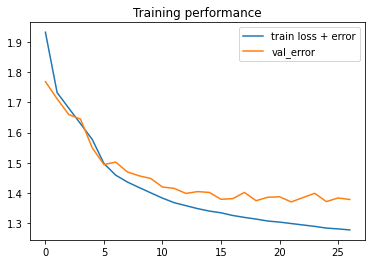

In [14]:
evaluationlib.show_loss_curves(history)

## Confusion matrix

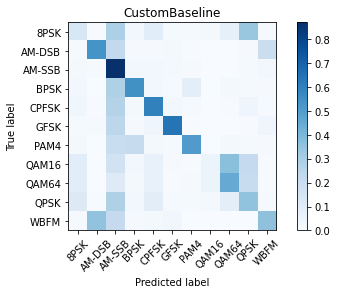

In [15]:
evaluationlib.plot_confusion_matrix(model, NEURAL_NETWORK_NAME, X_test, Y_test, BATCH_SIZE, classes)

## Confusion matrix for each SNR

Overall Accuracy:  0.08952451708766716


Overall Accuracy:  0.09168207024029575


Overall Accuracy:  0.09685401201838105


Overall Accuracy:  0.10927617709065354


Overall Accuracy:  0.125


Overall Accuracy:  0.16720372359470104


Overall Accuracy:  0.2816194912217843


Overall Accuracy:  0.40806686046511625


Overall Accuracy:  0.4458643947461839


Overall Accuracy:  0.5611071171818836


Overall Accuracy:  0.6416122004357299


Overall Accuracy:  0.6895059502344032


Overall Accuracy:  0.6838709677419355


Overall Accuracy:  0.6895522388059702
Overall Accuracy:  0.6840778097982709


Overall Accuracy:  0.6915785636164783
Overall Accuracy:  0.6730840429470566


Overall Accuracy:  0.6901090635577285


Overall Accuracy:  0.6997052321296978


Overall Accuracy:  0.667741935483871


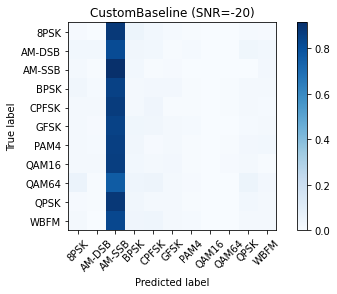

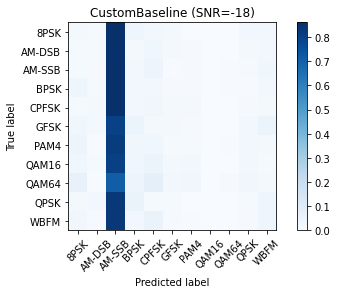

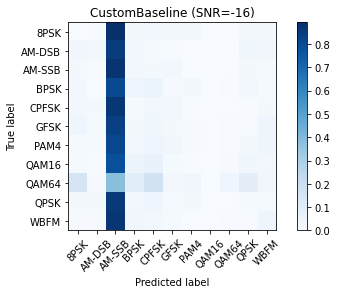

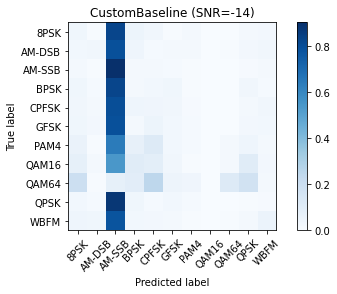

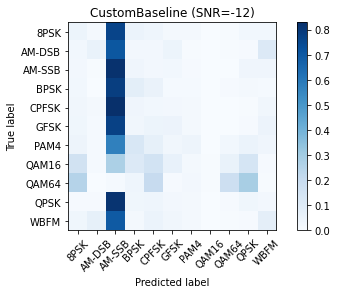

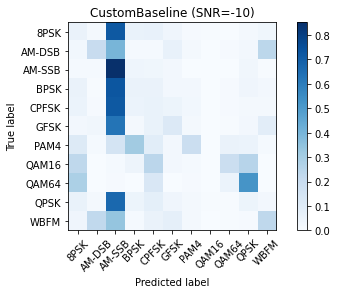

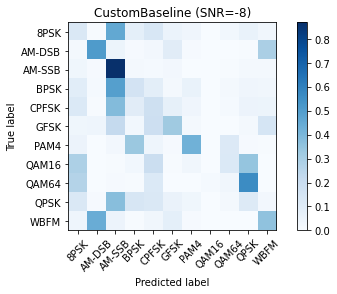

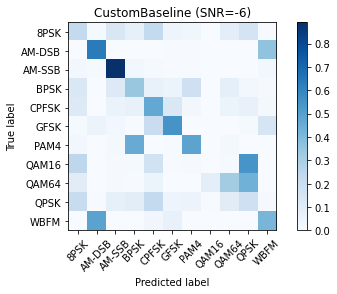

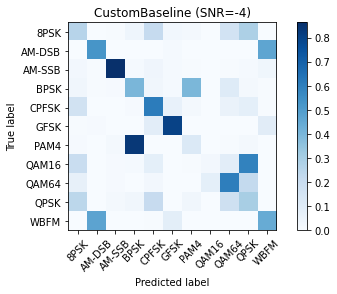

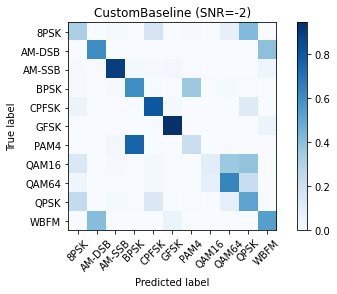

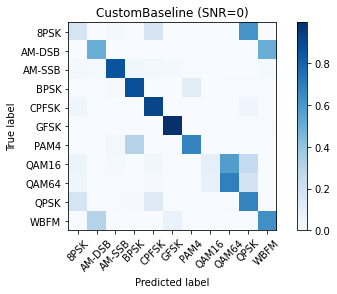

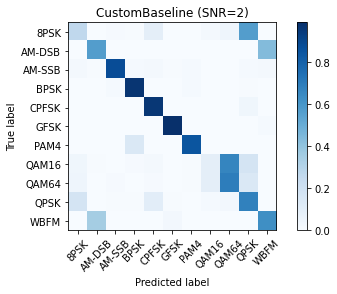

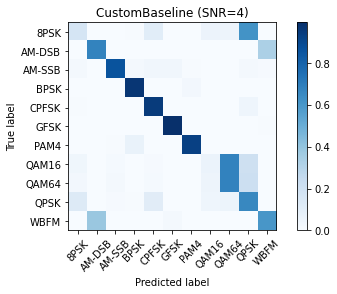

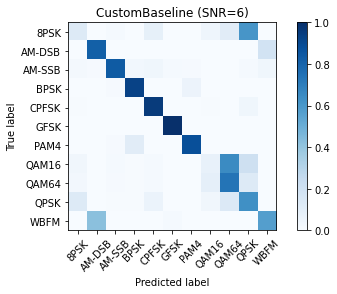

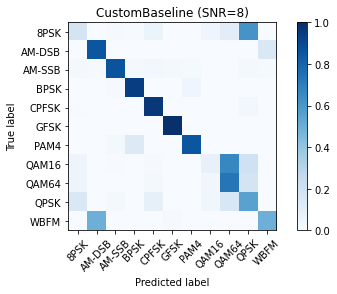

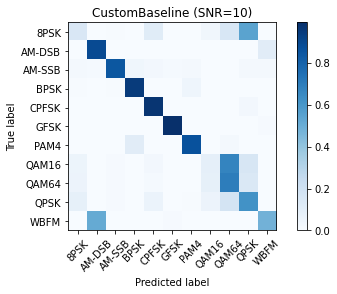

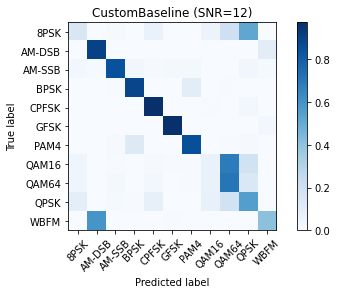

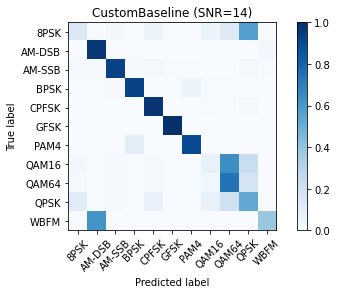

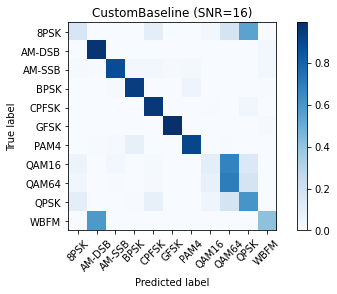

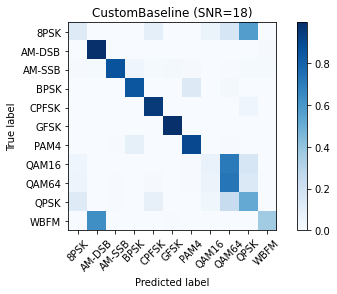

In [16]:
acc = evaluationlib.plot_confusion_matrix_each_snr(model, NEURAL_NETWORK_NAME, snrs, dataset_df, X_test, Y_test, test_index, classes)

## Accuracy performance

In [17]:
evaluationlib.accuracy_dataframe(acc)

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,8,9,9,10,12,16,28,40,44,56,64,68,68,68,68,69,67,69,69,66


In [18]:
import statistics

statistics.mean(acc.values())

0.4593518184198904

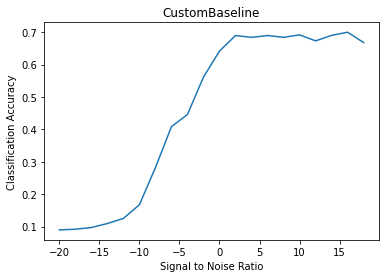

In [19]:
evaluationlib.accuracy_curve(snrs, acc, NEURAL_NETWORK_NAME)